In [1]:
#import 구문들
from numba import jit
# from sklearnex import patch_sklearn
# patch_sklearn()
from imblearn.under_sampling import TomekLinks, OneSidedSelection, RandomUnderSampler

from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif,chi2
import plotly.graph_objects as go
from imblearn.combine import SMOTETomek
from eli5.sklearn import PermutationImportance
import eli5
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from imblearn.under_sampling import *
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline

# from lightgbm import LGBMClassifier
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

from impyute.imputation.cs import mice

In [2]:
#Cross Validation 학습 함수 코드

def CVROC(model,con_col, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=Ran_state)
    prob = pd.DataFrame(columns=['LR', 'SVM', 'RF', 'XGB', 'GT'])
    pred = pd.DataFrame(columns=['LR', 'SVM', 'RF', 'XGB', 'GT'])
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier = model.copy()
        cv_train_x = X.iloc[train]
        cv_train_y = y.iloc[train]
        cv_test_x = X.iloc[test]
        cv_test_y = y.iloc[test]
        
        if len(con_col) != 0:
            DFS = cv_train_x.loc[:,con_col]
            cv_train_x = cv_train_x.drop(DFS,1)
            DFST = cv_test_x.loc[:,con_col]
            cv_test_x = cv_test_x.drop(DFST,1)

            MM = StandardScaler()
            DFSMM = MM.fit_transform(DFS)
            DFS = pd.DataFrame(DFSMM, columns=con_col, index=cv_train_x.index)
            cv_train_x = pd.concat([cv_train_x,DFS],1)
            
            MM = StandardScaler()
            DFSMM = MM.fit_transform(DFST)
            DFST = pd.DataFrame(DFSMM, columns=con_col,index=cv_test_x.index)
            cv_test_x = pd.concat([cv_test_x,DFST],1)
        LR = classifier[0].fit(cv_train_x, cv_train_y)
        SVM = classifier[1].fit(cv_train_x, cv_train_y)
        RF = classifier[2].fit(cv_train_x, cv_train_y)
        XGB = classifier[3].fit(cv_train_x, cv_train_y)
        lrproba = LR.predict_proba(cv_test_x)[:, -1]
        rfproba = RF.predict_proba(cv_test_x)[:, -1]
        xgbproba = XGB.predict_proba(cv_test_x)[:, -1]
        SVMproba = SVM.predict_proba(cv_test_x)[:, -1]

        lrpred = (LR.predict_proba(cv_test_x)[:, 1] >= 0.5).astype(int)
        rfpred = (RF.predict_proba(cv_test_x)[:, 1] >= 0.5).astype(int)
        xgbpred = (XGB.predict_proba(cv_test_x)[:, 1] >= 0.5).astype(int)
        SVMpred = (SVM.predict_proba(cv_test_x)[:, 1] >= 0.5).astype(int)

        foldprob = pd.DataFrame(list(zip(lrproba, SVMproba, rfproba, xgbproba,  cv_test_y.values)),
                                columns=['LR', 'SVM', 'RF', 'XGB', 'GT'])
        foldpred = pd.DataFrame(list(zip(lrpred, SVMpred, rfpred, xgbpred,  cv_test_y.values)),
                                columns=['LR', 'SVM', 'RF', 'XGB', 'GT'])
        prob = prob.append(foldprob)
        pred = pred.append(foldpred)
    prob.to_csv("sev-CV.csv")
    lrfpr, lrtpr, _ = roc_curve(list(prob['GT']), list(prob['LR']))
    SVMfpr, SVMtpr, _ = roc_curve(list(prob['GT']), list(prob['SVM']))
    rffpr, rftpr, _ = roc_curve(list(prob['GT']), list(prob['RF']))
    xgbfpr, xgbtpr, _ = roc_curve(list(prob['GT']), list(prob['XGB']))
    lrauc = auc(lrfpr, lrtpr)
    SVMauc = auc(SVMfpr, SVMtpr)
    rfauc = auc(rffpr, rftpr)
    xgbauc = auc(xgbfpr, xgbtpr)

    print('LR')
    tn, fp, fn, tp = confusion_matrix(
        list(pred['GT']), list(pred['LR'])).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))

    print('SVM')
    tn, fp, fn, tp = confusion_matrix(
        list(pred['GT']), list(pred['SVM'])).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))

    print('RF')
    tn, fp, fn, tp = confusion_matrix(
        list(pred['GT']), list(pred['RF'])).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))

    print('XGB')
    tn, fp, fn, tp = confusion_matrix(
        list(pred['GT']), list(pred['XGB'])).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))

    plt.figure(dpi=300, facecolor='white')
    rcParams['font.family'] = "Times New Roman"
    rcParams["legend.facecolor"] = 'white'
#     rcParams["legend.edgecolor"] = 'white'
    plt.plot(lrfpr, lrtpr,  label="LR (AUC= %.4f)" % (round(lrauc, 4)),color='gray',linestyle='solid')
    plt.plot(SVMfpr, SVMtpr, label="SVM (AUC= %.4f)" % (round(SVMauc, 4)),color='gray',linestyle='dashed')
    plt.plot(rffpr, rftpr,  label="RF (AUC= %.4f)" % (round(rfauc, 4)),color='gray',linestyle='dotted')
    plt.plot(xgbfpr, xgbtpr, label="XGB (AUC= %.4f)" % (round(xgbauc, 4)),color='gray',linestyle='-.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1-specificity', fontsize=18)
    plt.ylabel('sensitivity', fontsize=18)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
#train/test 나눠서 학습하는 코드    
    
def create_curve(classlist, train_x, train_y, test_x, test_y):
    LR = classlist[0]
    SVM = classlist[1]
    RF = classlist[2]
    XGB = classlist[3]

    LR.fit(train_x, train_y)
    RF.fit(train_x, train_y)
    XGB.fit(train_x, train_y)
    SVM.fit(train_x, train_y)

    print('==========================================')
    print(train_x.columns)
    print('==========================================')

    lr_pred = (LR.predict_proba(test_x)[:, 1] >= 0.5).astype(int)
    SVM_pred = (SVM.predict_proba(test_x)[:, 1] >= 0.5).astype(int)
    rf_pred = (RF.predict_proba(test_x)[:, 1] >= 0.5).astype(int)
    xgb_pred = (XGB.predict_proba(test_x)[:, 1] >= 0.5).astype(int)
    
    print(LR.coef_[0])
    print(np.exp(LR.coef_[0]))
    coefdf = pd.DataFrame(list(zip(train_x.columns,list(LR.coef_[0]),list(np.exp(LR.coef_[0])))),columns=['features','coef','odds_ratio'])
    print(coefdf)
    coefdf.to_csv("coef_sev.csv")

    print(rf_pred)

    LR_proba = LR.predict_proba(test_x)[:, 1]
    rf_proba = RF.predict_proba(test_x)[:, 1]
    xgb_proba = XGB.predict_proba(test_x)[:, 1]
    SVM_proba = SVM.predict_proba(test_x)[:, 1]
    proba = pd.DataFrame(list(zip(test_y.values, LR_proba, SVM_proba, rf_proba, xgb_proba)), columns=[
                         'GT', 'LR', 'SVM', 'RF', 'XGB'])
    proba.to_csv("sev-int.csv")

    fpr_LR, tpr_LR, _ = roc_curve(test_y, LR_proba)
    fpr_rf, tpr_rf, _ = roc_curve(test_y, rf_proba)
    fpr_xgb, tpr_xgb, _ = roc_curve(test_y, xgb_proba)
    fpr_SVM, tpr_SVM, _ = roc_curve(test_y, SVM_proba)

    print('LR')
    tn, fp, fn, tp = confusion_matrix(test_y, lr_pred).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))
    print('SVM')
    tn, fp, fn, tp = confusion_matrix(test_y, SVM_pred).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))
    print('RF')
    tn, fp, fn, tp = confusion_matrix(test_y, rf_pred).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))
    print('XGB')
    tn, fp, fn, tp = confusion_matrix(test_y, xgb_pred).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))


    auc_LR = auc(fpr_LR, tpr_LR)
    auc_xgb = auc(fpr_xgb, tpr_xgb)
    auc_rf = auc(fpr_rf, tpr_rf)
    auc_SVM = auc(fpr_SVM, tpr_SVM)

    plt.figure(dpi=300, facecolor='white')
    rcParams['font.family'] = "Times New Roman"
    rcParams["legend.facecolor"] = 'white'
    rcParams["legend.edgecolor"] = 'white'
    plt.plot(fpr_LR, tpr_LR, label="LR (AUC= %.4f)" % (round(auc_LR, 4)),color='gray',linestyle='solid')
    plt.plot(fpr_SVM, tpr_SVM, label="SVM (AUC= %.4f)" % (round(auc_SVM, 4)),color='gray',linestyle='dashed')
    plt.plot(fpr_rf, tpr_rf, label="RF (AUC= %.4f)" % (round(auc_rf, 4)),color='gray',linestyle='dotted')
    plt.plot(fpr_xgb, tpr_xgb, label="XGB (AUC= %.4f)" % (round(auc_xgb, 4)),color='gray',linestyle='-.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1-specificity', fontsize=18)
    plt.ylabel('sensitivity', fontsize=18)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

    Importance = pd.DataFrame(train_x.columns, columns=['feature'])
    suf = ('_LR','_SVM', '_RF', '_XGB' )

    for i in range(4):
        
        PI = P_Importance(classlist[i], test_x,
                          test_y).loc[:, ['feature', 'weight']]
        Importance = pd.merge(Importance, PI, on='feature',
                              suffixes=(suf[i-1], suf[i]))

    Importance['meanscore'] = Importance.apply(lambda x: np.mean(x[1:5]), 1)
    ftr_top20 = Importance.sort_values(ascending=False, by='meanscore')[:]

    fig = go.Figure([go.Bar(x=ftr_top20.meanscore, y=ftr_top20.feature, orientation='h', marker={
                    'color': ftr_top20.meanscore, 'colorscale': [[0, '#DDDDDD'], [1.0, 'black']]})])
    fig.update_layout(

        font=dict(
            family='Times New Roman',
            size=18
        ),
        autosize=False,
        width=900,
        height=600,
        #     xaxis=dict(type='category',tickfont_size=15),
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig.show()

    return classlist,Importance
def cv_pre(X,y,train,test,con_col,i):
        cv_train_x = X[i].iloc[train]
        cv_train_y = y.iloc[train]
        cv_test_x = X[i].iloc[test]
        cv_test_y = y.iloc[test]
        
        
        if len(con_col[i]) != 0:
            DFS = cv_train_x.loc[:,con_col[i]]
            cv_train_x = cv_train_x.drop(DFS,1)
            DFST = cv_test_x.loc[:,con_col[i]]
            cv_test_x = cv_test_x.drop(DFST,1)

            MM = StandardScaler()
            DFSMM = MM.fit_transform(DFS)
            DFS = pd.DataFrame(DFSMM, columns=con_col[i], index=cv_train_x.index)
            cv_train_x = pd.concat([cv_train_x,DFS],1)
            
#             MM = StandardScaler()
            DFSMM = MM.transform(DFST)
            DFST = pd.DataFrame(DFSMM, columns=con_col[i],index=cv_test_x.index)
            cv_test_x = pd.concat([cv_test_x,DFST],1)
            
            print(len(cv_test_x))
            
        return cv_train_x,cv_test_x,cv_train_y,cv_test_y
    

def CVROC_select(model,con_col, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=Ran_state)
    prob = pd.DataFrame(columns=['LR', 'SVM', 'RF', 'XGB', 'GT'])
    pred = pd.DataFrame(columns=['LR', 'SVM', 'RF', 'XGB', 'GT'])
    for i, (train, test) in enumerate(cv.split(X[0], y)):
        classifier = model.copy()
        
        cv_train_LR,cv_test_LR,cv_train_y,cv_test_y = cv_pre(X,y,train,test,con_col,0)
        cv_train_SVM,cv_test_SVM,cv_train_y,cv_test_y = cv_pre(X,y,train,test,con_col,1)
        cv_train_RF,cv_test_RF,cv_train_y,cv_test_y = cv_pre(X,y,train,test,con_col,2)
        cv_train_XGB,cv_test_XGB,cv_train_y,cv_test_y = cv_pre(X,y,train,test,con_col,3)
        
        cv_train = [cv_train_LR,cv_train_SVM,cv_train_RF,cv_train_XGB]
        cv_test = [cv_test_LR,cv_test_SVM,cv_test_RF,cv_test_XGB]

        LR = classifier[0].fit(cv_train_LR, cv_train_y)
        SVM = classifier[1].fit(cv_train_SVM, cv_train_y)
        RF = classifier[2].fit(cv_train_RF, cv_train_y)
        XGB = classifier[3].fit(cv_train_XGB, cv_train_y)
        lrproba = LR.predict_proba(cv_test_LR)[:, -1]
        rfproba = RF.predict_proba(cv_test_RF)[:, -1]
        xgbproba = XGB.predict_proba(cv_test_XGB)[:, -1]
        SVMproba = SVM.predict_proba(cv_test_SVM)[:, -1]

        lrpred = (LR.predict_proba(cv_test_LR)[:, 1] >= 0.5).astype(int)
        rfpred = (RF.predict_proba(cv_test_RF)[:, 1] >= 0.5).astype(int)
        xgbpred = (XGB.predict_proba(cv_test_XGB)[:, 1] >= 0.5).astype(int)
        SVMpred = (SVM.predict_proba(cv_test_SVM)[:, 1] >= 0.5).astype(int)

        foldprob = pd.DataFrame(list(zip(lrproba, SVMproba, rfproba, xgbproba,  cv_test_y.values)),
                                columns=['LR', 'SVM', 'RF', 'XGB', 'GT'])
        foldpred = pd.DataFrame(list(zip(lrpred, SVMpred, rfpred, xgbpred,  cv_test_y.values)),
                                columns=['LR', 'SVM', 'RF', 'XGB', 'GT'])
        prob = prob.append(foldprob)
        pred = pred.append(foldpred)
        
        suf = ('_LR','_SVM', '_RF', '_XGB' )
        weights = []
        for i in range(4):
            Importance = pd.DataFrame(cv_test[i].columns, columns=['feature'])
            weights.append(Importance)
            
        for i in range(4):
            print(len(cv_test[i]),len(test_y))
            PI = P_Importance(classlist[i], cv_test[i],
                              cv_test_y).loc[:, ['feature', 'weight']]
            weights[i] = pd.merge(weights[i], PI, on='feature', how='inner')
            weights[i]['meanscore'] = weights[i].apply(lambda x: np.mean(x[1:6]), 1)
            weights[i] = weights[i].sort_values(ascending=False, by='meanscore')[:]
            
    for i in range(4):
        fig = go.Figure([go.Bar(x=weights[i].meanscore, y=weights[i].feature, orientation='h', marker={
                        'color': weights[i].meanscore, 'colorscale': [[0, '#DDDDDD'], [1.0, 'black']]})])
        fig.update_layout(

            font=dict(
                family='Times New Roman',
                size=18
            ),
            autosize=False,
            width=900,
            height=600,
            #     xaxis=dict(type='category',tickfont_size=15),
            plot_bgcolor='rgba(0,0,0,0)'
        )
        fig.show()

    prob.to_csv("sev-CV.csv")
    lrfpr, lrtpr, _ = roc_curve(list(prob['GT']), list(prob['LR']))
    SVMfpr, SVMtpr, _ = roc_curve(list(prob['GT']), list(prob['SVM']))
    rffpr, rftpr, _ = roc_curve(list(prob['GT']), list(prob['RF']))
    xgbfpr, xgbtpr, _ = roc_curve(list(prob['GT']), list(prob['XGB']))
    lrauc = auc(lrfpr, lrtpr)
    SVMauc = auc(SVMfpr, SVMtpr)
    rfauc = auc(rffpr, rftpr)
    xgbauc = auc(xgbfpr, xgbtpr)

    print('LR')
    tn, fp, fn, tp = confusion_matrix(
        list(pred['GT']), list(pred['LR'])).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))

    print('SVM')
    tn, fp, fn, tp = confusion_matrix(
        list(pred['GT']), list(pred['SVM'])).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))

    print('RF')
    tn, fp, fn, tp = confusion_matrix(
        list(pred['GT']), list(pred['RF'])).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))

    print('XGB')
    tn, fp, fn, tp = confusion_matrix(
        list(pred['GT']), list(pred['XGB'])).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))

    plt.figure(dpi=300, facecolor='white')
    rcParams['font.family'] = "Times New Roman"
    rcParams["legend.facecolor"] = 'white'
#     rcParams["legend.edgecolor"] = 'white'
    plt.plot(lrfpr, lrtpr,  label="LR (AUC= %.4f)" % (round(lrauc, 4)),color='gray',linestyle='solid')
    plt.plot(SVMfpr, SVMtpr, label="SVM (AUC= %.4f)" % (round(SVMauc, 4)),color='gray',linestyle='dashed')
    plt.plot(rffpr, rftpr,  label="RF (AUC= %.4f)" % (round(rfauc, 4)),color='gray',linestyle='dotted')
    plt.plot(xgbfpr, xgbtpr, label="XGB (AUC= %.4f)" % (round(xgbauc, 4)),color='gray',linestyle='-.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1-specificity', fontsize=18)
    plt.ylabel('sensitivity', fontsize=18)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
#train/test 나눠서 학습하는 코드    
    
def create_curve_select(classlist, train_x, train_y, test_x, test_y):
    LR = classlist[0]
    SVM = classlist[1]
    RF = classlist[2]
    XGB = classlist[3]

    LR.fit(train_x[0], train_y)
    RF.fit(train_x[2], train_y)
    XGB.fit(train_x[3], train_y)
    SVM.fit(train_x[1], train_y)

#     print('==========================================')
#     print(train_x.columns)
#     print('==========================================')

    lr_pred = (LR.predict_proba(test_x[0])[:, 1] >= 0.5).astype(int)
    SVM_pred = (SVM.predict_proba(test_x[1])[:, 1] >= 0.5).astype(int)
    rf_pred = (RF.predict_proba(test_x[2])[:, 1] >= 0.5).astype(int)
    xgb_pred = (XGB.predict_proba(test_x[3])[:, 1] >= 0.5).astype(int)

    print(rf_pred)

    LR_proba = LR.predict_proba(test_x[0])[:, 1]
    rf_proba = RF.predict_proba(test_x[2])[:, 1]
    xgb_proba = XGB.predict_proba(test_x[3])[:, 1]
    SVM_proba = SVM.predict_proba(test_x[1])[:, 1]
    proba = pd.DataFrame(list(zip(test_y.values, LR_proba, SVM_proba, rf_proba, xgb_proba)), columns=[
                         'GT', 'LR', 'SVM', 'RF', 'XGB'])
    proba.to_csv("sev-int.csv")

    fpr_LR, tpr_LR, _ = roc_curve(test_y, LR_proba)
    fpr_rf, tpr_rf, _ = roc_curve(test_y, rf_proba)
    fpr_xgb, tpr_xgb, _ = roc_curve(test_y, xgb_proba)
    fpr_SVM, tpr_SVM, _ = roc_curve(test_y, SVM_proba)

    print('LR')
    tn, fp, fn, tp = confusion_matrix(test_y, lr_pred).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))
    print('SVM')
    tn, fp, fn, tp = confusion_matrix(test_y, SVM_pred).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))
    print('RF')
    tn, fp, fn, tp = confusion_matrix(test_y, rf_pred).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))
    print('XGB')
    tn, fp, fn, tp = confusion_matrix(test_y, xgb_pred).ravel()
    print("tn = {} fp = {} fn = {} tp = {}".format(tn, fp, fn, tp))


    auc_LR = auc(fpr_LR, tpr_LR)
    auc_xgb = auc(fpr_xgb, tpr_xgb)
    auc_rf = auc(fpr_rf, tpr_rf)
    auc_SVM = auc(fpr_SVM, tpr_SVM)

    plt.figure(dpi=300, facecolor='white')
    rcParams['font.family'] = "Times New Roman"
    rcParams["legend.facecolor"] = 'white'
    rcParams["legend.edgecolor"] = 'white'
    plt.plot(fpr_LR, tpr_LR, label="LR (AUC= %.4f)" % (round(auc_LR, 4)),color='gray',linestyle='solid')
    plt.plot(fpr_SVM, tpr_SVM, label="SVM (AUC= %.4f)" % (round(auc_SVM, 4)),color='gray',linestyle='dashed')
    plt.plot(fpr_rf, tpr_rf, label="RF (AUC= %.4f)" % (round(auc_rf, 4)),color='gray',linestyle='dotted')
    plt.plot(fpr_xgb, tpr_xgb, label="XGB (AUC= %.4f)" % (round(auc_xgb, 4)),color='gray',linestyle='-.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1-specificity', fontsize=18)
    plt.ylabel('sensitivity', fontsize=18)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

    Importance = pd.DataFrame(train_x[0].columns, columns=['feature'])
    suf = ('_LR','_SVM', '_RF', '_XGB' )

    for i in range(4):
        PI = P_Importance(classlist[i], test_x[i],
                          test_y).loc[:, ['feature', 'weight']]
        Importance = pd.merge(Importance, PI, on='feature', how='outer',
                              suffixes=(suf[i-1], suf[i]))

    Importance['meanscore'] = Importance.apply(lambda x: np.mean(x[1:5]), 1)
    ftr_top20 = Importance.sort_values(ascending=False, by='meanscore')[:]

    fig = go.Figure([go.Bar(x=ftr_top20.meanscore, y=ftr_top20.feature, orientation='h', marker={
                    'color': ftr_top20.meanscore, 'colorscale': [[0, '#DDDDDD'], [1.0, 'black']]})])
    fig.update_layout(

        font=dict(
            family='Times New Roman',
            size=18
        ),
        autosize=False,
        width=900,
        height=600,
        #     xaxis=dict(type='category',tickfont_size=15),
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig.show()

    return classlist,Importance


def gridsearch(classlist,gridlist,train_x,train_y):
    cv_grid = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
    grid = GridSearchCV(classlist, gridlist, scoring = 'roc_auc', cv=cv_grid,verbose=2,n_jobs=1)  
    grid.fit(train_x, train_y)
    print(grid.best_params_)
    print(grid.best_score_)
    classlist = grid.best_estimator_
    return classlist


#변수별로 중요도를 측정해서 보여주는 코드
#permutation importance 라고 합니다.

def P_Importance(model, test_x, test_y):  # permutation importance 중요도 뽑기
    perm = PermutationImportance(
        model, scoring="roc_auc", random_state=Ran_state).fit(test_x, test_y)
    ftr_importances = eli5.format_as_dataframe(eli5.explain_weights(
        perm, top=255, feature_names=test_x.columns.tolist()))
    ftr_top = ftr_importances.sort_values(ascending=False, by='feature')[:]
    return ftr_top

#원하는 갯수의 변수가 남을때까지 변수를 하나씩 줄여나가는 코드
#기본세팅은 5개
#이것도 시간좀 걸림
#각각의 변수를 제거 했을때의 AUC 값을 측정하고, AUC값이 최대가 되게 하는 변수를 제거함.(<- 반복)

@jit
def mySBS(ftr_importances, train_x, train_y, model,num=4,maxf=8):
    ftr_bot = ftr_importances.sort_values(ascending=False, by='meanscore')
    RB = 0
    RBfeatures = []
    for j in range(len(ftr_importances)-num):
        best_score = 0
        for i in range(len(ftr_bot)):
            print(len(ftr_bot),i)
            CV_x = train_x.drop(ftr_bot.iloc[i][0], 1)
            Score = np.mean(cross_val_score(model, CV_x, train_y, scoring='roc_auc', cv=cv))
#             Score = np.mean([xgbCV])
            if Score >= best_score:
                best_score = Score
                print("best_score = ", best_score)
                print("feature = ", ftr_bot.iloc[i][0])
                best_drop = i
                
        train_x = train_x.drop(ftr_bot.iloc[best_drop][0], 1)
        ftr_bot = ftr_bot[ftr_bot['feature'] != ftr_bot.iloc[best_drop][0]]
        print("뿅")
        print(train_x.columns)
        print("뿅?")
        print(best_score,len(train_x.columns))
        print("뾰로롱?")
        if best_score >= RB and len(ftr_bot)<maxf:
            print("########################뿅뿅?")
            RB = best_score
            RBfeatures = train_x.columns
            print(RB)
            print(RBfeatures)
    return train_x.columns,RBfeatures

def mapping_1(value,small,big):
    if value > big : 
        return "hyper"
    elif value < small:
        return "hypo"
    else:
        return "normal"

In [3]:
Ran_state = 532 #random state 값 지정

In [4]:

# # 각 모델 파라미터 값 범위 지정해주는 코드

# LR_grid = {'penalty': Categorical(['l2']),
#            'C': Continuous(0.0001, 1000),
#            }

# RF_grid = {'max_depth': Integer(2, 300),  # max_depth: The maximum depth of the tree.
#            # n_estimators: The number of trees in the forest.
#            'n_estimators': Integer(50, 1000),
#            'min_samples_split': Integer(2, 50),
#            }

# XGB_grid = {'n_estimators': Integer(10, 1000),
#             'learning_rate': Continuous(0.00001, 0.1),
#             'max_depth': Integer(2, 30),
#             'use_label_encoder': Categorical([False]), 'eval_metric': Categorical(['mlogloss'])}

# MLP_grid = {'hidden_layer_sizes': Integer(10, 1000),
#             'activation': Categorical(['identity','logistic','tanh','relu']),
#             'solver' : Categorical(['sgd','adam']),
#             'alpha' : Continuous(0.000001,0.01),}

# # 모델 선언

# RF = RandomForestClassifier(random_state=Ran_state)
# XGB = XGBClassifier(random_state=Ran_state,max_iter=10000)
# LR = LogisticRegression(solver='liblinear',class_weight='balanced', max_iter=10000,random_state=Ran_state)
# MLP = MLPClassifier(random_state=Ran_state,max_iter=10000)

# # LR = LogisticRegression(C=505.4193985435098, random_state=84)
# # RF = RandomForestClassifier(max_depth=6, min_samples_split=7, n_estimators=63,
# #                         random_state=84)
# # XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
# #                colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
# #                eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
# #                interaction_constraints='', learning_rate=0.0264905646121304,
# #                max_delta_step=0, max_depth=13, min_child_weight=1,
# #                monotone_constraints='()', n_estimators=620, n_jobs=12,
# #                num_parallel_tree=1, predictor='auto', random_state=84,
# #                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
# #                tree_method='exact', use_label_encoder=False,
# #                validate_parameters=1, verbosity=None)
# # MLP = MLPClassifier(activation='logistic', alpha=0.0062056790449658205,
# #                hidden_layer_sizes=890, max_iter=500, random_state=84)


# gridlist = [LR_grid, RF_grid, XGB_grid, MLP_grid]
# classlist = [LR, RF, XGB, MLP]

In [5]:
RF_grid={'max_depth': [2,4,6,8], # max_depth: The maximum depth of the tree.
        'n_estimators': [100,200,400,600,800], # n_estimators: The number of trees in the forest.
        'min_samples_split': [2,5,10,12,25,7],'random_state' : [Ran_state],
        'min_samples_leaf': [1, 2, 4],
              }

XGB_grid={'n_estimators' : [100,200,300,400,500],
    "learning_rate": [0.0001,0.001, 0.01, 0.1] ,
    "max_depth": [2,4,6,8],
    "gamma": [i/10.0 for i in range(0,5)],
    'random_state' : [Ran_state]} 

# MLP_grid = {
#     'hidden_layer_sizes': [(5),(10,30,10),(20)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],'random_state' : [Ran_state]
# }

# SVM_grid = {
#     'C': [0.1, 1, 10, 100, 1000], 
#   'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#   'kernel': ['rbf'],
#     'random_state' : [Ran_state]
# }

param_range = [ 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# SVM_grid = {'C': param_range, 
#                'gamma': param_range, 
#                'kernel': ['rbf'],'random_state':[Ran_state]}

SVM_grid = [{'C': param_range, 
               'gamma': param_range, 
               'kernel': ['rbf'],'random_state':[Ran_state]},
            {'C': param_range, 
               'kernel': ['linear'],'random_state':[Ran_state]}]

c_range = np.logspace(-2, 2, 10)

# np.logspace(-3, 3, 10)
LR_grid = [{'penalty':['l1'],
    'C':c_range,
    'solver':['liblinear','saga'],
    'random_state' : [Ran_state]},
           {'penalty':['l2'],
    'C':c_range,
    'solver':['lbfgs', 'liblinear', 'neton-cg', 'newton-cholesky', 'sag', 'saga'],
    'random_state' : [Ran_state]},
            {'penalty':['elasticnet'],
    'C':c_range,
    'solver':['saga'],
    'random_state' : [Ran_state]}]

RF = RandomForestClassifier()
XGB = XGBClassifier(eval_metric='mlogloss')
SVM = SVC(probability=True)
LR = LogisticRegression(max_iter=1000)


gridlist = [LR_grid,SVM_grid,RF_grid,XGB_grid]
classlist = [LR,SVM,RF,XGB]

###GridSearchCV로 파라미터 튜닝을 위해 파라미터값 지정

In [6]:
'Age_75','Age_60','Age_45','BMI_18.5','BMI_23','BMI_25','BMI_30','BMI_Cat','Ranson_5','BISAP_3',
'CTSI_2','CTSI_4','CTSI_5','CTSI_7','CRP1_50','CRP1_100','CRP1_150','CRP2_50','CRP2_100','CRP2_150','CRP2_200'


('CTSI_2',
 'CTSI_4',
 'CTSI_5',
 'CTSI_7',
 'CRP1_50',
 'CRP1_100',
 'CRP1_150',
 'CRP2_50',
 'CRP2_100',
 'CRP2_150',
 'CRP2_200')

In [7]:
#데이터 로드

df = pd.read_csv('data_new.csv')
df = df.drop(['Hospital','SN','UN','Transfer','Hospital_stay',"ICU"], 1)
df = df.drop(['Age_75','Age_60','Age_45','BMI_18.5','BMI_23','BMI_25','BMI_30','BMI_Cat','Ranson_5','BISAP_3',
'CTSI_2','CTSI_4','CTSI_5','CTSI_7','CRP1_50','CRP1_100','CRP1_150',
], 1)
target = 'Endpoint'
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=Ran_state)

In [8]:
df

Endpoint  Age  Sex    BMI  DM  Alcohol  Smoking  Eti_Biliary  \
0            1   31    0  32.70   0        1        1            0   
1            0   49    0  23.00   0        1        1            0   
2            0   28    1  29.40   0        1        0            1   
3            1   41    0  27.60   0        1        1            0   
4            0   23    0  24.30   0        1        1            0   
...        ...  ...  ...    ...  ..      ...      ...          ...   
2445         0   28    1  25.17   0        0        0            1   
2446         0   32    1  32.22   0        1        1            1   
2447         1   48    0  19.60   1        1        1            0   
2448         1   32    0  31.46   1        1        0            0   
2449         1   56    1  21.63   0        0        0            0   

      Eti_Alcohol  Eti_TG  ...  Corrected_Ca    P   BUN    Cr  Alb    Amy1  \
0               1       0  ...          9.08  1.8   6.6  1.00  4.9   315.0   
1               1       1  ...          9.04  2.8  17.2  0.90  3.7    43.0   
2               0       0  ...          9.30  3.1  10.9  0.70  3.5  1732.0   
3               1       0  ...          9.06  3.5  30.0  1.60  3.3   229.0   
4               0       0  ...          9.16  4.1  16.3  0.70  3.8   623.0   
...           ...     ...  ...           ...  ...   ...   ...  ...     ...   
2445            0       0  ...          8.96  3.4  10.7  0.66  4.8   402.0   
2446            0       0  ...          8.78  3.0   9.6  0.52  4.9  1867.0   
2447            1       0  ...          9.30  4.0  22.1  1.07  4.6    53.0   
2448            0       1  ...          8.80  6.1  46.4  2.17  4.6   506.0   
2449            0       0  ...          8.30  3.6  23.7  1.20  3.9   586.0   

       Lipa1   CRP1   Amy2   Lipa2  
0     1361.0   19.7  511.0  1166.0  
1      144.0  196.4  108.0   189.0  
2     4010.0   21.1  853.0  1117.0  
3      688.0   10.7  228.0   609.0  
4     1806.0    0.2  136.0    61.0  
...      ...    ...    ...     ...  
2445  1728.0    2.6  212.0   124.0  
2446  5393.0    2.1  245.0   274.0  
2447   220.0    3.1   53.0   220.0  
2448  1540.0  135.2  741.0     NaN  
2449   577.0    NaN  586.0   577.0  

[2450 rows x 52 columns]

In [9]:
df.info()

#docsp_percent,nur_percent,pop21,hh21,pphh21,age,pop_growth,hhi,pt_num,pt_std

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Endpoint        2450 non-null   int64  
 1   Age             2450 non-null   int64  
 2   Sex             2450 non-null   int64  
 3   BMI             2437 non-null   float64
 4   DM              2450 non-null   int64  
 5   Alcohol         2450 non-null   int64  
 6   Smoking         2450 non-null   int64  
 7   Eti_Biliary     2450 non-null   int64  
 8   Eti_Alcohol     2450 non-null   int64  
 9   Eti_TG          2450 non-null   int64  
 10  Eti_AIP         2450 non-null   int64  
 11  EtI_neoplasm    2450 non-null   int64  
 12  Eti_Anatomic    2450 non-null   int64  
 13  Eti_Idiopathic  2450 non-null   int64  
 14  Alc-TG          2450 non-null   int64  
 15  AP_Hx           2450 non-null   int64  
 16  Fever_(adm)     2450 non-null   int64  
 17  MV              2450 non-null   i

In [10]:
#X, Y 분리 data_y는 라벨 data_x는 변수

data_y = df['Endpoint']
data_x = df.drop(['Endpoint'], 1)

#Y의 0,1 갯수 확인
data_x

Age  Sex    BMI  DM  Alcohol  Smoking  Eti_Biliary  Eti_Alcohol  Eti_TG  \
0      31    0  32.70   0        1        1            0            1       0   
1      49    0  23.00   0        1        1            0            1       1   
2      28    1  29.40   0        1        0            1            0       0   
3      41    0  27.60   0        1        1            0            1       0   
4      23    0  24.30   0        1        1            0            0       0   
...   ...  ...    ...  ..      ...      ...          ...          ...     ...   
2445   28    1  25.17   0        0        0            1            0       0   
2446   32    1  32.22   0        1        1            1            0       0   
2447   48    0  19.60   1        1        1            0            1       0   
2448   32    0  31.46   1        1        0            0            0       1   
2449   56    1  21.63   0        0        0            0            0       0   

      Eti_AIP  ...  Corrected_Ca    P   BUN    Cr  Alb    Amy1   Lipa1   CRP1  \
0           0  ...          9.08  1.8   6.6  1.00  4.9   315.0  1361.0   19.7   
1           0  ...          9.04  2.8  17.2  0.90  3.7    43.0   144.0  196.4   
2           0  ...          9.30  3.1  10.9  0.70  3.5  1732.0  4010.0   21.1   
3           0  ...          9.06  3.5  30.0  1.60  3.3   229.0   688.0   10.7   
4           0  ...          9.16  4.1  16.3  0.70  3.8   623.0  1806.0    0.2   
...       ...  ...           ...  ...   ...   ...  ...     ...     ...    ...   
2445        0  ...          8.96  3.4  10.7  0.66  4.8   402.0  1728.0    2.6   
2446        0  ...          8.78  3.0   9.6  0.52  4.9  1867.0  5393.0    2.1   
2447        0  ...          9.30  4.0  22.1  1.07  4.6    53.0   220.0    3.1   
2448        0  ...          8.80  6.1  46.4  2.17  4.6   506.0  1540.0  135.2   
2449        1  ...          8.30  3.6  23.7  1.20  3.9   586.0   577.0    NaN   

       Amy2   Lipa2  
0     511.0  1166.0  
1     108.0   189.0  
2     853.0  1117.0  
3     228.0   609.0  
4     136.0    61.0  
...     ...     ...  
2445  212.0   124.0  
2446  245.0   274.0  
2447   53.0   220.0  
2448  741.0     NaN  
2449  586.0   577.0  

[2450 rows x 51 columns]

In [11]:
data_imp = data_x.select_dtypes(include=[float])
data_not_imp = data_x.drop(data_imp,1)

np_imputed=mice(data_imp.values) # mice 학습시작
df_imputed = pd.DataFrame(np_imputed,columns=data_imp.columns)
data_x = pd.concat([data_not_imp,df_imputed],1)

In [12]:
# le = LabelEncoder()
# data_y['dname16'] = le.fit_transform(data_y['dname16'])

In [13]:
data_x_prot = data_x.iloc[:,:8]
data_x = data_x.drop(data_x_prot,1)

In [14]:
# data_x_prot

In [15]:
#변수-라벨이 아닌 변수-변수간에 연관성이 높으면 학습에 악영향(다중공선성)
#그런걸 방지하기 위해 연관성이 높은 변수부터 하나씩 지워나가는 코드


for i in range(len(data_x.columns)):
    vif = pd.DataFrame()
    vif["features"] = data_x.columns
    vif["VIF Factor"] = [variance_inflation_factor(
        data_x.values, i) for i in range(data_x.shape[1])]
    vif_remove = vif.sort_values(ascending=False, by='VIF Factor')[:]
    if vif_remove.iloc[0][1] > 10.0:
        print(vif_remove.iloc[0][0])
        data_x = data_x.drop([vif_remove.iloc[0][0]], 1)

Ca
Severity
Hct
Corrected_Ca
Alb
Hb
BMI
ANP


In [16]:
# data_x = pd.concat([data_x_prot,data_x],1)

In [17]:
#다중공선성 수치 확인하는 코드
#10 이상인 수치들은 높은거라 지워야됨

vif = pd.DataFrame()
vif["features"] = data_x.columns
vif["VIF Factor"] = [variance_inflation_factor(
    data_x.values, i) for i in range(data_x.shape[1])]
vif_remove = vif.sort_values(ascending=False, by='VIF Factor')[:]
vif_remove

features  VIF Factor
23             WBC    9.321069
27               P    9.060069
15             PLT    8.304936
28             BUN    7.588837
20          Ranson    5.993299
22            CTSI    5.133021
21           BISAP    4.786712
26             Glc    4.700412
11    Severity_bin    4.653566
29              Cr    4.198736
33            Amy2    3.852002
30            Amy1    3.283696
24             ALT    2.987666
16             AST    2.867760
12      SIRS_(adm)    2.741975
31           Lipa1    2.532505
34           Lipa2    2.399947
13        OF_(adm)    2.372695
19   Renal_failure    2.256220
25           T_bil    2.022399
6      Fever_(adm)    1.812190
32            CRP1    1.806607
18         Hypoxia    1.797816
14        OF_(48h)    1.752263
7               MV    1.619985
17           Shock    1.552196
5            AP_Hx    1.537300
8              RRT    1.406245
4           Alc-TG    1.244940
3   Eti_Idiopathic    1.224034
0          Eti_AIP    1.055727
2     Eti_Anatomic    1.047619
9              GIB    1.045166
1     EtI_neoplasm    1.039469
10  Pseudoaneurysm    1.007776

연속형 변수들 StandardScaler 진행

In [18]:
#학습용/검증용 데이터 분리해주는 코드
#학습용 7 테스트 3으로 나누는데 테스트사이즈 조정해서 비율 조정 가능

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3, random_state=Ran_state, stratify=data_y)

In [19]:
train_x.columns = data_x.columns
test_x.columns = data_x.columns

In [20]:
iscon = ~data_x.columns.isin(data_imp)
data_con = train_x.loc[:,iscon]
con_col = data_con.columns

In [21]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1715 entries, 1120 to 1649
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Eti_AIP         1715 non-null   int64  
 1   EtI_neoplasm    1715 non-null   int64  
 2   Eti_Anatomic    1715 non-null   int64  
 3   Eti_Idiopathic  1715 non-null   int64  
 4   Alc-TG          1715 non-null   int64  
 5   AP_Hx           1715 non-null   int64  
 6   Fever_(adm)     1715 non-null   int64  
 7   MV              1715 non-null   int64  
 8   RRT             1715 non-null   int64  
 9   GIB             1715 non-null   int64  
 10  Pseudoaneurysm  1715 non-null   int64  
 11  Severity_bin    1715 non-null   int64  
 12  SIRS_(adm)      1715 non-null   int64  
 13  OF_(adm)        1715 non-null   int64  
 14  OF_(48h)        1715 non-null   int64  
 15  PLT             1715 non-null   int64  
 16  AST             1715 non-null   int64  
 17  Shock           1715 non-null 

In [22]:
iscon

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [23]:
train_x.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)


DFS = train_x.loc[:,con_col]
train_x = train_x.drop(DFS,1)
DFST = test_x.loc[:,con_col]
test_x = test_x.drop(DFST,1)

MM = StandardScaler()
DFSMM = MM.fit_transform(DFS)
DFS = pd.DataFrame(DFSMM, columns=con_col)
train_x = pd.concat([train_x,DFS],1)

# MM = StandardScaler()
DFSMM = MM.transform(DFST)
DFST = pd.DataFrame(DFSMM, columns=con_col)
test_x = pd.concat([test_x,DFST],1)

In [24]:
con_col

Index(['Eti_AIP', 'EtI_neoplasm', 'Eti_Anatomic', 'Eti_Idiopathic', 'Alc-TG',
       'AP_Hx', 'Fever_(adm)', 'MV', 'RRT', 'GIB', 'Pseudoaneurysm',
       'Severity_bin', 'SIRS_(adm)', 'OF_(adm)', 'OF_(48h)', 'PLT', 'AST'],
      dtype='object')

In [25]:
train_x

Shock  Hypoxia  Renal_failure  Ranson  BISAP  CTSI    WBC    ALT  T_bil  \
0       0.0      0.0            0.0     1.0    0.0   3.0  11.73   49.0   0.22   
1       0.0      0.0            1.0     2.0    2.0   4.0  12.72  123.0   1.70   
2       0.0      0.0            0.0     3.0    3.0   3.0   9.03   44.0   0.91   
3       1.0      1.0            0.0     6.0    2.0   1.0  15.13   15.0   0.23   
4       0.0      0.0            0.0     1.0    0.0   3.0  12.46  394.0   2.10   
...     ...      ...            ...     ...    ...   ...    ...    ...    ...   
1710    0.0      0.0            0.0     2.0    0.0   3.0  10.52   38.0   1.00   
1711    0.0      0.0            0.0     2.0    0.0   2.0   9.60  101.0   3.40   
1712    0.0      0.0            0.0     2.0    1.0   4.0  13.12   68.0   0.72   
1713    0.0      0.0            0.0     3.0    2.0   3.0  13.54   45.0   0.69   
1714    1.0      1.0            0.0     3.0    2.0   4.0   6.56    7.0   0.70   

        Glc  ...        MV        RRT       GIB  Pseudoaneurysm  Severity_bin  \
0     110.0  ... -0.124071  -0.097043 -0.076584       -0.034169      0.757228   
1     102.0  ... -0.124071  -0.097043 -0.076584       -0.034169      0.757228   
2     173.0  ... -0.124071  -0.097043 -0.076584       -0.034169      0.757228   
3     241.0  ...  8.059872  10.304732 -0.076584       -0.034169      0.757228   
4     164.0  ... -0.124071  -0.097043 -0.076584       -0.034169      0.757228   
...     ...  ...       ...        ...       ...             ...           ...   
1710  140.0  ... -0.124071  -0.097043 -0.076584       -0.034169      0.757228   
1711  135.0  ... -0.124071  -0.097043 -0.076584       -0.034169     -1.320606   
1712  310.0  ... -0.124071  -0.097043 -0.076584       -0.034169      0.757228   
1713   81.0  ... -0.124071  -0.097043 -0.076584       -0.034169      0.757228   
1714  249.0  ... -0.124071  -0.097043 -0.076584       -0.034169      0.757228   

      SIRS_(adm)  OF_(adm)  OF_(48h)       PLT       AST  
0      -0.978653 -0.379600 -0.239451  2.219949 -0.270592  
1       1.021812 -0.379600 -0.239451 -1.046849 -0.487068  
2       1.021812 -0.379600 -0.239451 -0.777543 -0.475674  
3       1.021812  2.634353  4.176226  0.896838 -0.589609  
4       1.021812 -0.379600 -0.239451 -0.215513  0.625697  
...          ...       ...       ...       ...       ...  
1710   -0.978653 -0.379600 -0.239451  1.212979 -0.376931  
1711   -0.978653 -0.379600 -0.239451 -0.707289  0.291487  
1712    1.021812 -0.379600 -0.239451  0.229427 -0.395920  
1713    1.021812 -0.379600 -0.239451  0.065502 -0.342750  
1714    1.021812  2.634353  4.176226 -0.098423 -0.502259  

[1715 rows x 35 columns]

하이퍼 파라미터 조정용 GridsearchCV 진행

In [26]:
train_y.value_counts()

0    1661
1      54
Name: Endpoint, dtype: int64

In [27]:
# train_x, train_y = OneSidedSelection(random_state=Ran_state).fit_resample(train_x,train_y)
# train_y.value_counts()

In [28]:
# # 엄청 오래걸림. 모델 4개 각각 파라미터 돌림.

# classlist[0] = gridsearch(classlist[0], gridlist[0], train_x, train_y)
# classlist[1] = gridsearch(classlist[1], gridlist[1], train_x, train_y)
# classlist[2] = gridsearch(classlist[2], gridlist[2], train_x, train_y)
# classlist[3] = gridsearch(classlist[3], gridlist[3], train_x, train_y)

In [29]:
# # #엄청 오래걸림. 모델 4개 각각 파라미터 돌림.

# classlist[0] = geneticsearch(classlist[0], gridlist[0], train_x, train_y)
# classlist[1] = geneticsearch(classlist[1], gridlist[1], train_x, train_y)
# classlist[2] = geneticsearch(classlist[2], gridlist[2], train_x, train_y)
# classlist[3] = geneticsearch(classlist[3], gridlist[3], train_x, train_y)

In [30]:
#파라미터 조정 결과 확인

classlist

[LogisticRegression(max_iter=1000),
 SVC(probability=True),
 RandomForestClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss', gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None,
               reg_alpha=None, reg_lambda=None, ...)]

In [31]:
#CV 스코어로 결과 잘 나왔는지 확인한거.
#중간확인정도로 한거라 그냥 지나가도 됨

LRCV = np.mean(cross_val_score(
    classlist[0], train_x, train_y, scoring='roc_auc', cv=cv))
RFCV = np.mean(cross_val_score(
    classlist[1], train_x, train_y, scoring='roc_auc', cv=cv))
XGBCV = np.mean(cross_val_score(
    classlist[2], train_x, train_y, scoring='roc_auc', cv=cv))
SVMCV = np.mean(cross_val_score(
    classlist[3], train_x, train_y, scoring='roc_auc', cv=cv))

print(LRCV)
print(RFCV)
print(XGBCV)
print(SVMCV)

0.7321206200724273
0.5791608695223154
0.8333922915248216
0.8382290176266078


In [32]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Shock           1715 non-null   float64
 1   Hypoxia         1715 non-null   float64
 2   Renal_failure   1715 non-null   float64
 3   Ranson          1715 non-null   float64
 4   BISAP           1715 non-null   float64
 5   CTSI            1715 non-null   float64
 6   WBC             1715 non-null   float64
 7   ALT             1715 non-null   float64
 8   T_bil           1715 non-null   float64
 9   Glc             1715 non-null   float64
 10  P               1715 non-null   float64
 11  BUN             1715 non-null   float64
 12  Cr              1715 non-null   float64
 13  Amy1            1715 non-null   float64
 14  Lipa1           1715 non-null   float64
 15  CRP1            1715 non-null   float64
 16  Amy2            1715 non-null   float64
 17  Lipa2           1715 non-null   f

==================================================================

학습 및 예측

Index(['Shock', 'Hypoxia', 'Renal_failure', 'Ranson', 'BISAP', 'CTSI', 'WBC',
       'ALT', 'T_bil', 'Glc', 'P', 'BUN', 'Cr', 'Amy1', 'Lipa1', 'CRP1',
       'Amy2', 'Lipa2', 'Eti_AIP', 'EtI_neoplasm', 'Eti_Anatomic',
       'Eti_Idiopathic', 'Alc-TG', 'AP_Hx', 'Fever_(adm)', 'MV', 'RRT', 'GIB',
       'Pseudoaneurysm', 'Severity_bin', 'SIRS_(adm)', 'OF_(adm)', 'OF_(48h)',
       'PLT', 'AST'],
      dtype='object')
[ 2.20037647e-02  7.21748930e-02  8.86348384e-02 -7.23133029e-02
  2.73398229e-01  1.94604191e-01 -1.45678689e-01 -1.11983143e-03
 -3.55267603e-01  2.27633160e-03 -9.00394331e-01 -3.43282228e-04
 -1.00164368e-01 -3.26700203e-04  8.12910314e-05  1.33300684e-04
  2.36459164e-03 -6.70884599e-04  1.21693548e-01  6.24701855e-02
  4.48810735e-02 -7.72803537e-02 -1.07864373e-01  6.80296702e-02
  6.43888753e-02  1.43956358e-01  4.56290509e-01  9.69233937e-02
  5.05230131e-01  2.67622744e-01  4.16669839e-01  5.99789201e-02
  2.35273166e-01  5.53232244e-01  2.07834065e-01]
[1.0222476

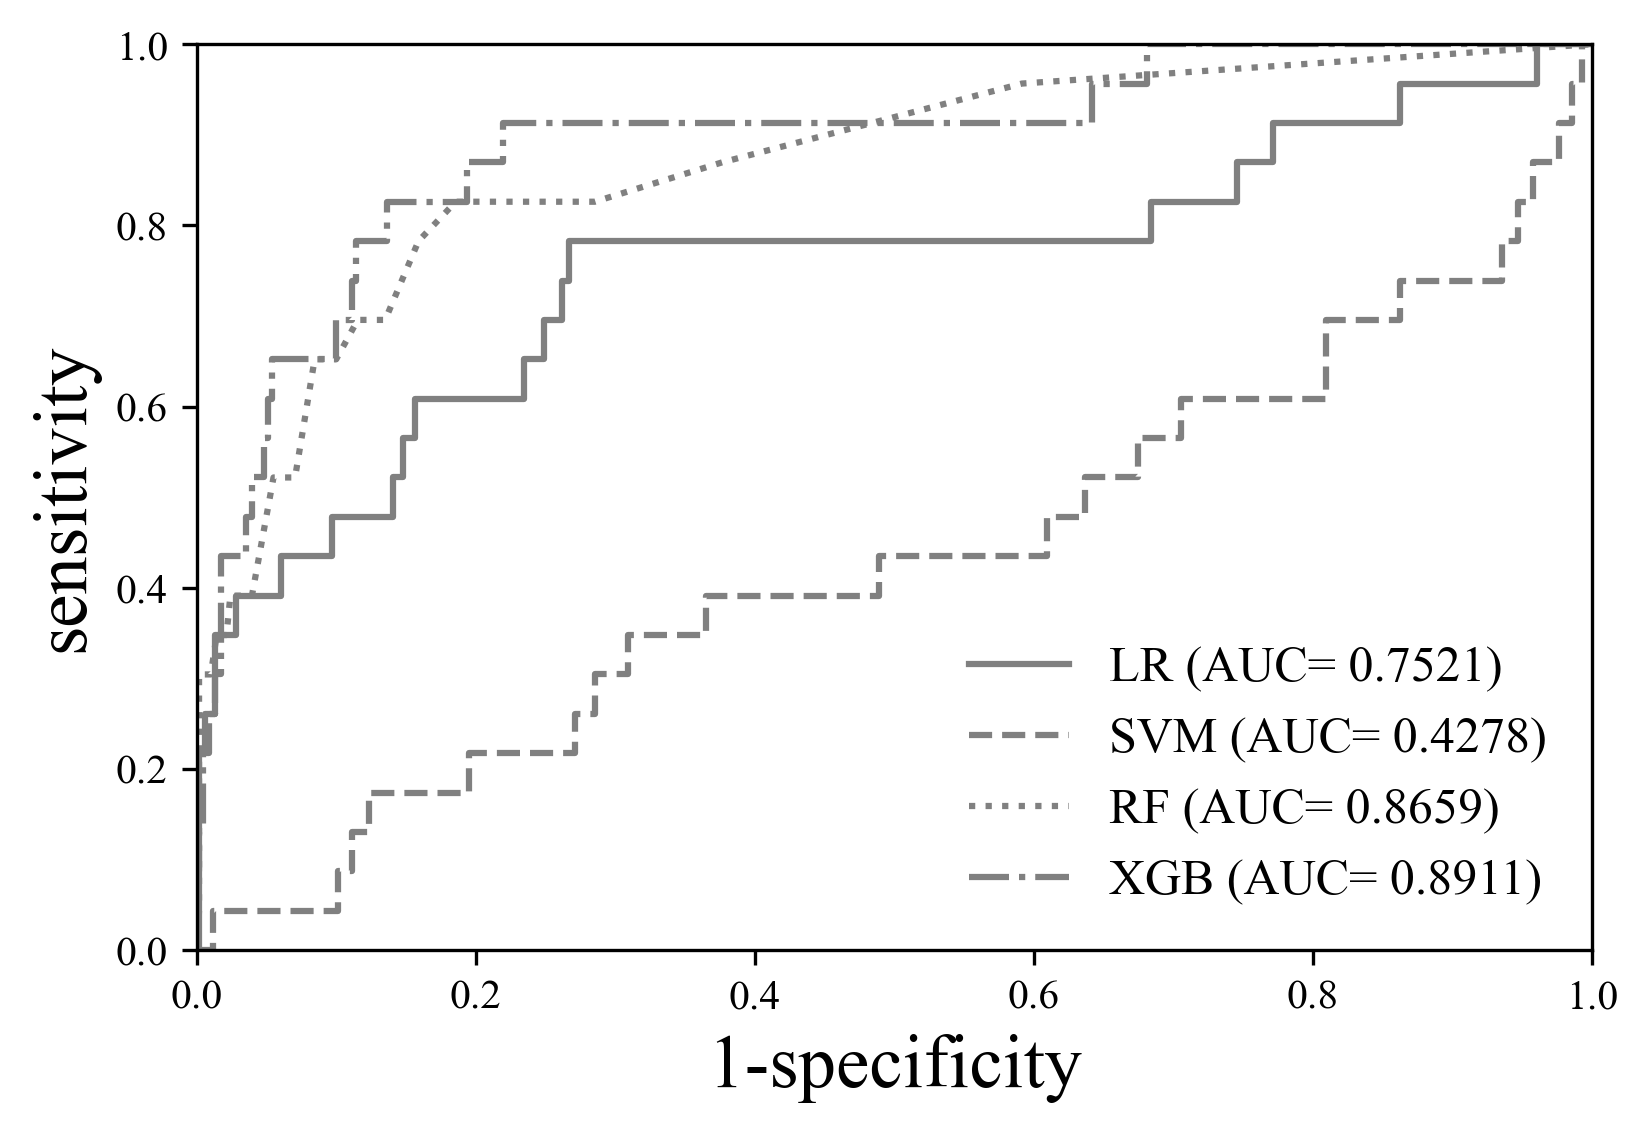

In [33]:
#학습해보기

classlist,ftr_importances = create_curve(classlist, train_x, train_y, test_x, test_y)

In [34]:
# a = ['region_cat_11', 'sex_cat_2', 'ho_incm5_cat_5', 'occp_cat_6',
#        'genertn_cat_4', 'marri_1_cat_2', 'marri_2_cat_2', 'D_1_1_cat_4',
#        'D_1_1_cat_5', 'DI3_dg_cat_1', 'DM3_lt_cat_1', 'DM3_dg_cat_1',
#        'educ_cat_2', 'educ_cat_3', 'educ_cat_4', 'educ_cat_7', 'BO1_cat_2',
#        'BO1_cat_4', 'mh_stress_cat_1', 'HE_HPdg_cat_1', 'HE_hCHOL_cat_1',
#        'Occ_cat_3']
# d_drop = data_x.drop(a, 1)
# data_x = data_x.drop(d_drop.columns, 1)
# train_x, test_x, train_y, test_y = train_test_split(
#     data_x, data_y, test_size=0.5, stratify=data_y, random_state=Ran_state)
# ftr_importances = create_curve(classlist, train_x, train_y, test_x, test_y)

In [35]:
# protect=['sex','age','fever','CRP','reference']
# for f in protect:
#     idx = ftr_importances[ftr_importances['feature'].str.contains(f)].index
#     ftr_importances.drop(idx,inplace=True)

In [36]:
ftr_importances

feature  weight_LR    weight_SVM  weight_RF    weight_XGB  \
0            Shock   0.000061  1.221299e-05   0.000641 -4.640938e-04   
1          Hypoxia  -0.000562 -2.442599e-05  -0.007627 -4.995115e-03   
2    Renal_failure  -0.001185  0.000000e+00  -0.000995 -1.465559e-03   
3           Ranson  -0.001979  2.198339e-04  -0.006937 -2.210552e-03   
4            BISAP   0.005313 -6.106497e-05   0.026862  1.968735e-02   
5             CTSI   0.013361  3.334148e-03   0.014649  1.922325e-02   
6              WBC  -0.002211  1.221299e-04  -0.000134  1.735467e-02   
7              ALT  -0.010320  2.718613e-02   0.019150  1.133366e-02   
8            T_bil   0.049377 -7.327797e-05   0.004714  1.061309e-02   
9              Glc   0.013092  6.167562e-03  -0.004116 -2.220446e-17   
10               P  -0.000745  2.442599e-05   0.003291  6.362970e-03   
11             BUN  -0.000122 -3.297509e-04   0.006717  4.665364e-03   
12              Cr   0.003175  3.663898e-05   0.006522  1.515633e-02   
13            Amy1   0.002870 -1.348315e-02  -0.006009 -1.282364e-03   
14           Lipa1  -0.006094  1.718368e-02  -0.014466  2.034685e-02   
15            CRP1  -0.000085  2.310699e-02   0.013660  9.404006e-04   
16            Amy2   0.030801 -1.910112e-02   0.014094  1.457010e-02   
17           Lipa2   0.029433 -5.508061e-03  -0.003639 -5.923302e-03   
18         Eti_AIP  -0.000171  6.106497e-05   0.001319  0.000000e+00   
19    EtI_neoplasm  -0.002467 -9.770396e-05  -0.000446  0.000000e+00   
20    Eti_Anatomic   0.001563 -6.106497e-05  -0.000208  0.000000e+00   
21  Eti_Idiopathic   0.001453  1.343429e-04   0.000055  0.000000e+00   
22          Alc-TG  -0.003127 -2.808989e-04   0.000067  0.000000e+00   
23           AP_Hx   0.003249 -8.881784e-17  -0.000714  0.000000e+00   
24     Fever_(adm)   0.003554 -6.106497e-05   0.002876  5.495848e-04   
25              MV   0.002015  9.770396e-04   0.003017  9.159746e-04   
26             RRT  -0.002443  1.245725e-03  -0.000073  1.001466e-03   
27             GIB  -0.000684  9.770396e-05  -0.000073  0.000000e+00   
28  Pseudoaneurysm   0.000159 -1.221299e-04  -0.000263  0.000000e+00   
29    Severity_bin   0.008415  9.770396e-05   0.000873  2.271617e-03   
30      SIRS_(adm)   0.003652 -2.931119e-04   0.001075  1.013679e-03   
31        OF_(adm)  -0.001026 -3.663898e-05  -0.000727  0.000000e+00   
32        OF_(48h)   0.007755  7.083537e-04   0.001221  3.663898e-04   
33             PLT   0.037042  5.495848e-04   0.046019  4.520029e-02   
34             AST  -0.005606  2.076209e-04   0.005697 -1.257938e-03   

    meanscore  
0    0.000063  
1   -0.003302  
2   -0.000911  
3   -0.002727  
4    0.012950  
5    0.012642  
6    0.003783  
7    0.011837  
8    0.016158  
9    0.003786  
10   0.002233  
11   0.002733  
12   0.006223  
13  -0.004476  
14   0.004242  
15   0.009406  
16   0.010091  
17   0.003591  
18   0.000302  
19  -0.000753  
20   0.000324  
21   0.000411  
22  -0.000835  
23   0.000634  
24   0.001730  
25   0.001731  
26  -0.000067  
27  -0.000165  
28  -0.000056  
29   0.002914  
30   0.001362  
31  -0.000447  
32   0.002513  
33   0.032203  
34  -0.000240

위에서 뽑은 importance 이용 Feature selection 과정

In [37]:
def selecting(RBfeatures,data_x,train_x,test_x):
    d_drop = data_x.drop(RBfeatures, 1)
    data_x = data_x.drop(d_drop.columns, 1)

    con_col = []
    for i in data_x.columns:
        if i in data_con.columns:
            con_col.append(i)

    print(con_col)

    train_x = train_x.drop(d_drop.columns, 1)
    test_x = test_x.drop(d_drop.columns, 1)
    return con_col,train_x,test_x,data_x

In [38]:
#Feature Selection 진행
#4개의 변수를 선택함(갯수조정 num으로 가능)
LRfeatures,LR_RBfeatures = mySBS(ftr_importances, train_x, train_y, classlist[0], num=4,maxf=12)
SVMfeatures,SVM_RBfeatures = mySBS(ftr_importances, train_x, train_y, classlist[1], num=4,maxf=12)
RFfeatures,RF_RBfeatures = mySBS(ftr_importances, train_x, train_y, classlist[2], num=4,maxf=12)
XGBfeatures,XGB_RBfeatures = mySBS(ftr_importances, train_x, train_y, classlist[3], num=4,maxf=12)

con_LR,train_LR,test_LR,data_LR = selecting(LR_RBfeatures,data_x,train_x,test_x)
con_SVM,train_SVM,test_SVM,data_SVM = selecting(SVM_RBfeatures,data_x,train_x,test_x)
con_RF,train_RF,test_RF,data_RF = selecting(RF_RBfeatures,data_x,train_x,test_x)
con_XGB,train_XGB,test_XGB,data_XGB = selecting(XGB_RBfeatures,data_x,train_x,test_x)



# train_x, train_y = OneSidedSelection(random_state=Ran_state).fit_resample(train_x,train_y)

35 0
best_score =  0.6966586740080716
feature =  PLT
35 1
best_score =  0.7419818504155854
feature =  T_bil
35 2
35 3
35 4
35 5
35 6
best_score =  0.748171917810472
feature =  CRP1
35 7
best_score =  0.7546054488223163
feature =  Cr
35 8
35 9
35 10
35 11
35 12
35 13
35 14
35 15
35 16
35 17
35 18
35 19
35 20
35 21
35 22
35 23
35 24
35 25
best_score =  0.7553098882014544
feature =  RRT
35 26
35 27
35 28
35 29
35 30
35 31
35 32
35 33
35 34
뿅
Index(['Shock', 'Hypoxia', 'Renal_failure', 'Ranson', 'BISAP', 'CTSI', 'WBC',
       'ALT', 'T_bil', 'Glc', 'P', 'BUN', 'Cr', 'Amy1', 'Lipa1', 'CRP1',
       'Amy2', 'Lipa2', 'Eti_AIP', 'EtI_neoplasm', 'Eti_Anatomic',
       'Eti_Idiopathic', 'Alc-TG', 'AP_Hx', 'Fever_(adm)', 'MV', 'GIB',
       'Pseudoaneurysm', 'Severity_bin', 'SIRS_(adm)', 'OF_(adm)', 'OF_(48h)',
       'PLT', 'AST'],
      dtype='object')
뿅?
0.7553098882014544 34
뾰로롱?
34 0
best_score =  0.7168779951912482
feature =  PLT
34 1
best_score =  0.7579810807521652
feature =  T_bil
34 2
3

25 16
best_score =  0.8547864841840747
feature =  Eti_Anatomic
25 17
25 18
25 19
25 20
25 21
25 22
25 23
25 24
뿅
Index(['Shock', 'Renal_failure', 'Ranson', 'BISAP', 'CTSI', 'ALT', 'Glc', 'P',
       'BUN', 'Cr', 'CRP1', 'Amy2', 'Lipa2', 'EtI_neoplasm', 'Alc-TG', 'AP_Hx',
       'Fever_(adm)', 'MV', 'Pseudoaneurysm', 'Severity_bin', 'SIRS_(adm)',
       'OF_(adm)', 'PLT', 'AST'],
      dtype='object')
뿅?
0.8547864841840747 24
뾰로롱?
24 0
best_score =  0.830911623562226
feature =  PLT
24 1
best_score =  0.8369402260968528
feature =  BISAP
24 2
best_score =  0.840403316788859
feature =  CTSI
24 3
best_score =  0.8521577875794742
feature =  ALT
24 4
24 5
best_score =  0.8582348394396588
feature =  CRP1
24 6
24 7
24 8
24 9
best_score =  0.8593921303559858
feature =  Severity_bin
24 10
24 11
24 12
24 13
24 14
24 15
24 16
24 17
24 18
24 19
24 20
24 21
24 22
24 23
뿅
Index(['Shock', 'Renal_failure', 'Ranson', 'BISAP', 'CTSI', 'ALT', 'Glc', 'P',
       'BUN', 'Cr', 'CRP1', 'Amy2', 'Lipa2', 'EtI_ne

12 5
12 6
12 7
12 8
best_score =  0.8684014024977881
feature =  BUN
12 9
12 10
12 11
뿅
Index(['Renal_failure', 'BISAP', 'CTSI', 'ALT', 'Glc', 'Cr', 'Amy2', 'Lipa2',
       'MV', 'Pseudoaneurysm', 'PLT'],
      dtype='object')
뿅?
0.8684014024977881 11
뾰로롱?
########################뿅뿅?
0.8684014024977881
Index(['Renal_failure', 'BISAP', 'CTSI', 'ALT', 'Glc', 'Cr', 'Amy2', 'Lipa2',
       'MV', 'Pseudoaneurysm', 'PLT'],
      dtype='object')
11 0
best_score =  0.847165829575468
feature =  PLT
11 1
best_score =  0.8541327965424351
feature =  BISAP
11 2
best_score =  0.8557792184298207
feature =  CTSI
11 3
best_score =  0.8671772100687762
feature =  ALT
11 4
11 5
11 6
11 7
11 8
11 9
11 10
뿅
Index(['Renal_failure', 'BISAP', 'CTSI', 'Glc', 'Cr', 'Amy2', 'Lipa2', 'MV',
       'Pseudoaneurysm', 'PLT'],
      dtype='object')
뿅?
0.8671772100687762 10
뾰로롱?
10 0
best_score =  0.8396633544826317
feature =  PLT
10 1
best_score =  0.8543500455548647
feature =  BISAP
10 2
10 3
best_score =  0.8558940430

best_score =  0.6237314861411247
feature =  PLT
28 1
28 2
28 3
28 4
28 5
28 6
28 7
28 8
28 9
28 10
best_score =  0.6276709129721177
feature =  BUN
28 11
28 12
28 13
28 14
28 15
28 16
28 17
28 18
28 19
28 20
28 21
28 22
28 23
28 24
28 25
28 26
28 27
뿅
Index(['Shock', 'Hypoxia', 'Renal_failure', 'BISAP', 'CTSI', 'ALT', 'Glc', 'P',
       'Cr', 'Amy1', 'CRP1', 'Amy2', 'Lipa2', 'Eti_AIP', 'EtI_neoplasm',
       'Eti_Idiopathic', 'Alc-TG', 'AP_Hx', 'MV', 'RRT', 'GIB',
       'Pseudoaneurysm', 'Severity_bin', 'SIRS_(adm)', 'OF_(48h)', 'PLT',
       'AST'],
      dtype='object')
뿅?
0.6276709129721177 27
뾰로롱?
27 0
best_score =  0.6213958536850104
feature =  PLT
27 1
27 2
best_score =  0.6239557081725755
feature =  CTSI
27 3
27 4
27 5
27 6
best_score =  0.6288420183600907
feature =  Cr
27 7
27 8
27 9
27 10
27 11
27 12
27 13
27 14
27 15
27 16
27 17
27 18
27 19
27 20
27 21
27 22
27 23
27 24
27 25
27 26
뿅
Index(['Shock', 'Hypoxia', 'Renal_failure', 'BISAP', 'CTSI', 'ALT', 'Glc', 'P',
       'Amy1'

best_score =  0.6085511250571491
feature =  CTSI
13 1
13 2
13 3
13 4
best_score =  0.6316880955435172
feature =  Severity_bin
13 5
13 6
13 7
best_score =  0.6342709412588932
feature =  Eti_Idiopathic
13 8
13 9
13 10
13 11
13 12
뿅
Index(['Hypoxia', 'Renal_failure', 'CTSI', 'Glc', 'Amy2', 'Lipa2',
       'EtI_neoplasm', 'Alc-TG', 'MV', 'RRT', 'Severity_bin', 'OF_(48h)'],
      dtype='object')
뿅?
0.6342709412588932 12
뾰로롱?
12 0
best_score =  0.6248391765259236
feature =  CTSI
12 1
12 2
12 3
12 4
best_score =  0.6328294998174517
feature =  Severity_bin
12 5
12 6
12 7
12 8
12 9
12 10
12 11
뿅
Index(['Hypoxia', 'Renal_failure', 'CTSI', 'Glc', 'Amy2', 'Lipa2',
       'EtI_neoplasm', 'Alc-TG', 'MV', 'RRT', 'OF_(48h)'],
      dtype='object')
뿅?
0.6328294998174517 11
뾰로롱?
########################뿅뿅?
0.6328294998174517
Index(['Hypoxia', 'Renal_failure', 'CTSI', 'Glc', 'Amy2', 'Lipa2',
       'EtI_neoplasm', 'Alc-TG', 'MV', 'RRT', 'OF_(48h)'],
      dtype='object')
11 0
best_score =  0.622586990056

best_score =  0.8384748658845045
feature =  PLT
28 1
best_score =  0.8485873715994199
feature =  T_bil
28 2
28 3
28 4
28 5
28 6
28 7
28 8
28 9
28 10
28 11
28 12
28 13
28 14
28 15
28 16
best_score =  0.8506314200290104
feature =  AP_Hx
28 17
28 18
28 19
28 20
28 21
28 22
28 23
28 24
28 25
28 26
28 27
뿅
Index(['Hypoxia', 'Renal_failure', 'Ranson', 'BISAP', 'CTSI', 'ALT', 'T_bil',
       'Glc', 'P', 'BUN', 'Cr', 'Amy1', 'Lipa1', 'CRP1', 'Amy2', 'Lipa2',
       'Eti_AIP', 'Eti_Anatomic', 'Alc-TG', 'Fever_(adm)', 'MV', 'RRT', 'GIB',
       'Severity_bin', 'OF_(adm)', 'PLT', 'AST'],
      dtype='object')
뿅?
0.8506314200290104 27
뾰로롱?
27 0
best_score =  0.8144519766206514
feature =  PLT
27 1
best_score =  0.8493759641350003
feature =  T_bil
27 2
27 3
27 4
27 5
27 6
27 7
27 8
27 9
27 10
27 11
27 12
27 13
27 14
27 15
27 16
27 17
27 18
27 19
27 20
27 21
27 22
27 23
27 24
27 25
27 26
뿅
Index(['Hypoxia', 'Renal_failure', 'Ranson', 'BISAP', 'CTSI', 'ALT', 'Glc',
       'P', 'BUN', 'Cr', 'Amy1', 'Li

best_score =  0.8308042982741778
feature =  PLT
14 1
14 2
14 3
14 4
14 5
14 6
best_score =  0.831925276865036
feature =  Severity_bin
14 7
14 8
14 9
best_score =  0.8460687302855977
feature =  MV
14 10
14 11
14 12
14 13
뿅
Index(['Hypoxia', 'BISAP', 'CTSI', 'ALT', 'P', 'BUN', 'CRP1', 'Amy2',
       'Eti_Anatomic', 'RRT', 'Severity_bin', 'PLT', 'AST'],
      dtype='object')
뿅?
0.8460687302855977 13
뾰로롱?
13 0
best_score =  0.8292092201730756
feature =  PLT
13 1
13 2
13 3
best_score =  0.8342795095204734
feature =  ALT
13 4
13 5
13 6
best_score =  0.8396240819132386
feature =  Severity_bin
13 7
13 8
13 9
13 10
best_score =  0.8452269191425816
feature =  RRT
13 11
13 12
뿅
Index(['Hypoxia', 'BISAP', 'CTSI', 'ALT', 'P', 'BUN', 'CRP1', 'Amy2',
       'Eti_Anatomic', 'Severity_bin', 'PLT', 'AST'],
      dtype='object')
뿅?
0.8452269191425816 12
뾰로롱?
12 0
best_score =  0.8271312605047545
feature =  PLT
12 1
12 2
12 3
12 4
12 5
12 6
best_score =  0.8358735515362021
feature =  Severity_bin
12 7
12 

best_score =  0.8380861694114706
feature =  T_bil
30 1
30 2
best_score =  0.8450758644734548
feature =  CTSI
30 3
best_score =  0.8569384499504981
feature =  ALT
30 4
30 5
30 6
30 7
30 8
30 9
30 10
best_score =  0.8595442868936845
feature =  Severity_bin
30 11
30 12
30 13
30 14
30 15
30 16
30 17
best_score =  0.8641284877429456
feature =  Eti_Idiopathic
30 18
best_score =  0.8664285972719707
feature =  Eti_Anatomic
30 19
30 20
30 21
best_score =  0.8664285972719707
feature =  Pseudoaneurysm
30 22
30 23
best_score =  0.8664285972719707
feature =  GIB
30 24
30 25
30 26
30 27
30 28
30 29
뿅
Index(['Shock', 'Hypoxia', 'Renal_failure', 'Ranson', 'BISAP', 'CTSI', 'ALT',
       'T_bil', 'Glc', 'P', 'BUN', 'Cr', 'Amy1', 'Lipa1', 'CRP1', 'Amy2',
       'Lipa2', 'Eti_AIP', 'Eti_Anatomic', 'Eti_Idiopathic', 'Alc-TG', 'AP_Hx',
       'MV', 'RRT', 'Pseudoaneurysm', 'Severity_bin', 'SIRS_(adm)', 'OF_(48h)',
       'AST'],
      dtype='object')
뿅?
0.8664285972719707 29
뾰로롱?
29 0
best_score =  0.838086

best_score =  0.8663728131198012
feature =  T_bil
17 1
17 2
17 3
17 4
best_score =  0.8762459173302547
feature =  CRP1
17 5
17 6
17 7
17 8
17 9
best_score =  0.8767300158866425
feature =  OF_(48h)
17 10
17 11
17 12
best_score =  0.877906548388476
feature =  RRT
17 13
17 14
17 15
best_score =  0.8844182298399165
feature =  Ranson
17 16
뿅
Index(['Shock', 'Hypoxia', 'Renal_failure', 'BISAP', 'CTSI', 'T_bil', 'Glc',
       'P', 'BUN', 'Cr', 'Lipa1', 'CRP1', 'Amy2', 'RRT', 'OF_(48h)', 'AST'],
      dtype='object')
뿅?
0.8844182298399165 16
뾰로롱?
16 0
best_score =  0.8551070786010545
feature =  T_bil
16 1
16 2
16 3
16 4
best_score =  0.8587269635462407
feature =  CRP1
16 5
16 6
16 7
best_score =  0.8607407188130078
feature =  Glc
16 8
16 9
best_score =  0.8744671067562633
feature =  OF_(48h)
16 10
16 11
16 12
16 13
16 14
16 15
뿅
Index(['Shock', 'Hypoxia', 'Renal_failure', 'BISAP', 'CTSI', 'T_bil', 'Glc',
       'P', 'BUN', 'Cr', 'Lipa1', 'CRP1', 'Amy2', 'RRT', 'AST'],
      dtype='object')
뿅?


In [39]:
XGB_RBfeatures

Index(['Hypoxia', 'Renal_failure', 'BISAP', 'CTSI', 'BUN', 'Cr', 'Lipa1',
       'Amy2'],
      dtype='object')

In [40]:
# 다시 파라미터 조정해주고
classlist[0] = gridsearch(classlist[0], gridlist[0], train_LR, train_y)
classlist[1] = gridsearch(classlist[1], gridlist[1], train_SVM, train_y)
classlist[2] = gridsearch(classlist[2], gridlist[2], train_RF, train_y)
classlist[3] = gridsearch(classlist[3], gridlist[3], train_XGB, train_y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END C=0.01, penalty=l1, random_state=532, solver=liblinear; total time=   0.0s
[CV] END C=0.01, penalty=l1, random_state=532, solver=liblinear; total time=   0.0s
[CV] END C=0.01, penalty=l1, random_state=532, solver=liblinear; total time=   0.0s
[CV] END C=0.01, penalty=l1, random_state=532, solver=liblinear; total time=   0.0s
[CV] END C=0.01, penalty=l1, random_state=532, solver=liblinear; total time=   0.0s
[CV] END ..C=0.01, penalty=l1, random_state=532, solver=saga; total time=   0.2s
[CV] END ..C=0.01, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END ..C=0.01, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END ..C=0.01, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END ..C=0.01, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END C=0.027825594022071243, penalty=l1, random_state=532, solver=liblinear; total time=   0.0s
[CV] END C=0.

[CV] END C=35.93813663804626, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END C=35.93813663804626, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END C=35.93813663804626, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END C=100.0, penalty=l1, random_state=532, solver=liblinear; total time=  13.9s
[CV] END C=100.0, penalty=l1, random_state=532, solver=liblinear; total time=  14.1s
[CV] END C=100.0, penalty=l1, random_state=532, solver=liblinear; total time=  14.4s
[CV] END C=100.0, penalty=l1, random_state=532, solver=liblinear; total time=  14.1s
[CV] END C=100.0, penalty=l1, random_state=532, solver=liblinear; total time=  13.7s
[CV] END .C=100.0, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END .C=100.0, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END .C=100.0, penalty=l1, random_state=532, solver=saga; total time=   0.1s
[CV] END .C=100.0, penalty=l1, random_state=532, solver=

[CV] END C=0.0774263682681127, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=0.0774263682681127, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=0.0774263682681127, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=0.0774263682681127, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=0.0774263682681127, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=0.0774263682681127, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=0.0774263682681127, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=0.0774263682681127, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=0.0774263682681127, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=0.21544346900318834, penalty=l2, random_state=532, solver=lbfgs; total time=   0.5s
[CV] END C=0.21544346900318834, penalty=l2, random_state=532, solver=lbf

[CV] END C=1.6681005372000592, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=1.6681005372000592, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=1.6681005372000592, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=1.6681005372000592, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=1.6681005372000592, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=1.6681005372000592, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=1.6681005372000592, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=1.6681005372000592, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=1.6681005372000592, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=4.6415888336127775, penalty=l2, random_state=532, solver=lbfgs; total time=   0.5s
[CV] END C=4.6415888336127775, penalty=l2, random_state=532, solver=lbfgs

[CV] END C=35.93813663804626, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=35.93813663804626, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=35.93813663804626, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=35.93813663804626, penalty=l2, random_state=532, solver=sag; total time=   0.0s
[CV] END C=35.93813663804626, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=35.93813663804626, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=35.93813663804626, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=35.93813663804626, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=35.93813663804626, penalty=l2, random_state=532, solver=saga; total time=   0.1s
[CV] END C=100.0, penalty=l2, random_state=532, solver=lbfgs; total time=   0.5s
[CV] END C=100.0, penalty=l2, random_state=532, solver=lbfgs; total time=   0.2s
[CV] END C=100

[CV] END .C=0.001, gamma=0.001, kernel=rbf, random_state=532; total time=   0.0s
[CV] END .C=0.001, gamma=0.001, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ..C=0.001, gamma=0.01, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ..C=0.001, gamma=0.01, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ..C=0.001, gamma=0.01, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ..C=0.001, gamma=0.01, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ..C=0.001, gamma=0.01, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ...C=0.001, gamma=0.1, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ...C=0.001, gamma=0.1, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ...C=0.001, gamma=0.1, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ...C=0.001, gamma=0.1, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ...C=0.001, gamma=0.1, kernel=rbf, random_state=532; total time=   0.0s
[CV] END ...C=0.001, gamma=1

[CV] END .....C=1.0, gamma=1.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END .....C=1.0, gamma=1.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END .....C=1.0, gamma=1.0, kernel=rbf, random_state=532; total time=   0.7s
[CV] END .....C=1.0, gamma=1.0, kernel=rbf, random_state=532; total time=   0.7s
[CV] END .....C=1.0, gamma=1.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END ....C=1.0, gamma=10.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END ....C=1.0, gamma=10.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END ....C=1.0, gamma=10.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END ....C=1.0, gamma=10.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END ....C=1.0, gamma=10.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END ...C=1.0, gamma=100.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END ...C=1.0, gamma=100.0, kernel=rbf, random_state=532; total time=   0.6s
[CV] END ...C=1.0, gamma=100

[CV] END ...........C=100.0, kernel=linear, random_state=532; total time=15.4min
[CV] END ...........C=100.0, kernel=linear, random_state=532; total time=20.3min
[CV] END ...........C=100.0, kernel=linear, random_state=532; total time=15.2min
{'C': 0.001, 'kernel': 'linear', 'random_state': 532}
0.692566926181384
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_sampl

[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=1, min_sa

[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=7, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=7, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=7, n_estimators=400, random_state=532; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=7, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=7, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=7, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=7, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=7, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_sp

[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=532; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=532; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=532; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=532; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=532; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=532; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=532; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=532; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=2, min_sa

[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=7, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=7, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=7, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=7, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200, random_state=532; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200, random_state=532; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200, random_state=532; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200, random_state=532; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_sp

[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=4, min_sample

[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=25, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=25, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=4, min_samples_split=25, n_estimators=800, random_state=532; total time=   0.8s
[CV] END max_depth=2, min_samples_leaf=4, min_sa

[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_sp

[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=25, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=25, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=25, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=1, min_sa

[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_sp

[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=12, n_estimators=800, random_state=532; total time=   0.9s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=12, n_estimators=800, random_state=532; total time=   0.9s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=12, n_estimators=800, random_state=532; total time=   0.9s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=12, n_estimators=800, random_state=532; total time=   0.9s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=25, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=25, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=25, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=25, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=4, min_samples_leaf=2, min_sa

[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=800, random_state=532; total time=   0.9s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=800, random_state=532; total time=   0.9s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=800, random_state=532; total time=   0.9s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=800, random_state=532; total time=   0.9s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_sp

[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=12, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=12, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=12, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=12, n_estimators=400, random_state=532; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=12, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=12, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=12, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=12, n_estimators=600, random_state=532; total time=   0.6s
[CV] END max_depth=4, min_samples_leaf=4, min_sa

[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_sp

[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=1, min_sa

[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=7, n_estimators=800, random_state=532; total time=   1.0s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=7, n_estimators=800, random_state=532; total time=   1.0s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=7, n_estimators=800, random_state=532; total time=   1.0s
[CV] END max_depth=6, min_samples_leaf=1, min_samples_split=7, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_sp

[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=800, random_state=532; total time=   1.0s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=800, random_state=532; total time=   1.0s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=800, random_state=532; total time=   1.0s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=800, random_state=532; total time=   1.0s
[CV] END max_depth=6, min_samples_leaf=2, min_sa

[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=600, random_state=532; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_sp

[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=6, min_samples_leaf=4, min_sa

[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=25, n_estimators=800, random_state=532; total time=   1.0s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=7, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=7, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=7, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=7, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=7, n_estimators=100, random_state=532; total time=   0.0s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=7, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=7, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_s

[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=600, random_state=532; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_

[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=25, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=25, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=25, n_estimators=600, random_state=532; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=25, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_sa

[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=532; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=600, random_state=532; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_sp

[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=25, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=25, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=25, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=25, n_estimators=400, random_state=532; total time=   0.6s
[CV] END max_depth=8, min_samples_leaf=2, min_sa

[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=2, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=2, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=200, random_state=532; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_sp

[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=12, n_estimators=600, random_state=532; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=12, n_estimators=600, random_state=532; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=12, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=12, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=12, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=12, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=12, n_estimators=800, random_state=532; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=25, n_estimators=100, random_state=532; total time=   0.1s
[CV] END max_depth=8, min_samples_leaf=4, min_sa

[CV] END gamma=0.0, learning_rate=0.0001, max_depth=2, n_estimators=300, random_state=532; total time=   0.0s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=2, n_estimators=300, random_state=532; total time=   0.0s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=2, n_estimators=300, random_state=532; total time=   0.0s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END g

[CV] END gamma=0.0, learning_rate=0.0001, max_depth=8, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=8, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=8, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=8, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=8, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=8, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.0001, max_depth=8, n_estimators=500, random_state=532; total time=   0.2s
[CV] END g

[CV] END gamma=0.0, learning_rate=0.001, max_depth=6, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=6, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=6, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=6, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0,

[CV] END gamma=0.0, learning_rate=0.01, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.01, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning

[CV] END gamma=0.0, learning_rate=0.1, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.0, learning_rate=0.1

[CV] END gamma=0.0, learning_rate=0.1, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=8, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=8, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=8, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=8, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.0, learning_rate=0.1, max_depth=8, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning

[CV] END gamma=0.1, learning_rate=0.0001, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=6, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=6, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=6, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=6, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=6, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.0001, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END g

[CV] END gamma=0.1, learning_rate=0.001, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.001, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.001, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.001, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.001, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.001, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1,

[CV] END gamma=0.1, learning_rate=0.01, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning

[CV] END gamma=0.1, learning_rate=0.01, max_depth=8, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=8, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=8, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=8, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate

[CV] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=8, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=8, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.1

[CV] END gamma=0.2, learning_rate=0.0001, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.2, learning_rate=0.0001, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.0001, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.0001, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.0001, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.0001, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.0001, max_depth=6, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.0001, max_depth=6, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.0001, max_depth=6, n_estimators=200, random_state=532; total time=   0.0s
[CV] END g

[CV] END gamma=0.2, learning_rate=0.001, max_depth=2, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.2, learning_rate=0.001, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.001, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.001, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.001, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.001, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.001, max_depth=4, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.001, max_depth=4, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.001, max_depth=4, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2,

[CV] END gamma=0.2, learning_rate=0.01, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=2, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=2, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=2, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=2, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=2, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=2, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=2, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning

[CV] END gamma=0.2, learning_rate=0.01, max_depth=8, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=8, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=8, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=8, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=8, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=8, n_estimators=300, random_state=532; total time=   0.2s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=8, n_estimators=300, random_state=532; total time=   0.2s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=8, n_estimators=300, random_state=532; total time=   0.2s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=8, n_estimators=300, random_state=532; total time=   0.2s
[CV] END gamma=0.2, learning

[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=200, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.2, learning_rate=0.1

[CV] END gamma=0.3, learning_rate=0.0001, max_depth=4, n_estimators=200, random_state=532; total time=   0.0s
[CV] END gamma=0.3, learning_rate=0.0001, max_depth=4, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.0001, max_depth=4, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.0001, max_depth=4, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.0001, max_depth=4, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.0001, max_depth=4, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.0001, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.0001, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.0001, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END g

[CV] END gamma=0.3, learning_rate=0.001, max_depth=2, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=2, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=2, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=2, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=2, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.3,

[CV] END gamma=0.3, learning_rate=0.001, max_depth=8, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=8, n_estimators=300, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=8, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=8, n_estimators=300, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3,

[CV] END gamma=0.3, learning_rate=0.01, max_depth=6, n_estimators=300, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=6, n_estimators=300, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=6, n_estimators=300, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=6, n_estimators=400, random_state=532; total time=   0.3s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=6, n_estimators=400, random_state=532; total time=   0.3s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=6, n_estimators=400, random_state=532; total time=   0.3s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=6, n_estimators=400, random_state=532; total time=   0.3s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=6, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.3, learning

[CV] END gamma=0.3, learning_rate=0.1, max_depth=4, n_estimators=300, random_state=532; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.1, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.1, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.1, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.1, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.1, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.1, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.1, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.1, max_depth=4, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.1

[CV] END gamma=0.4, learning_rate=0.0001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=2, n_estimators=400, random_state=532; total time=   0.1s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=2, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=2, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=2, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=2, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=2, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END g

[CV] END gamma=0.4, learning_rate=0.0001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=8, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=8, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=8, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=8, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=8, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.0001, max_depth=8, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.001, max_depth=2, n_estimators=100, random_state=532; total time=   0.0s
[CV] END ga

[CV] END gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.001, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.001, max_depth=8, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4,

[CV] END gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=400, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.01, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.01, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.01, max_depth=6, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4, learning

[CV] END gamma=0.4, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=532; total time=   0.2s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=532; total time=   0.1s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=4, n_estimators=100, random_state=532; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1

[CV] END gamma=0.4, learning_rate=0.1, max_depth=8, n_estimators=500, random_state=532; total time=   0.3s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=8, n_estimators=500, random_state=532; total time=   0.3s
{'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'random_state': 532}
0.8848792056020971


In [41]:
# #엄청 오래걸림. 모델 4개 각각 파라미터 돌림.

# classlist[0] = geneticsearch(classlist[0], gridlist[0], train_x, train_y)
# classlist[1] = geneticsearch(classlist[1], gridlist[1], train_x, train_y)
# classlist[2] = geneticsearch(classlist[2], gridlist[2], train_x, train_y)
# classlist[3] = geneticsearch(classlist[3], gridlist[3], train_x, train_y)

In [42]:
classlist

[LogisticRegression(C=12.915496650148826, max_iter=1000, penalty='l1',
                    random_state=532, solver='liblinear'),
 SVC(C=0.001, kernel='linear', probability=True, random_state=532),
 RandomForestClassifier(max_depth=6, min_samples_split=12, random_state=532),
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='mlogloss', gamma=0.4, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_bin=256,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=200, n_jobs=0, num_parallel_tree=1, predictor='auto',
               random_state=532, reg_alpha=0, reg_lambda=1, ...)]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

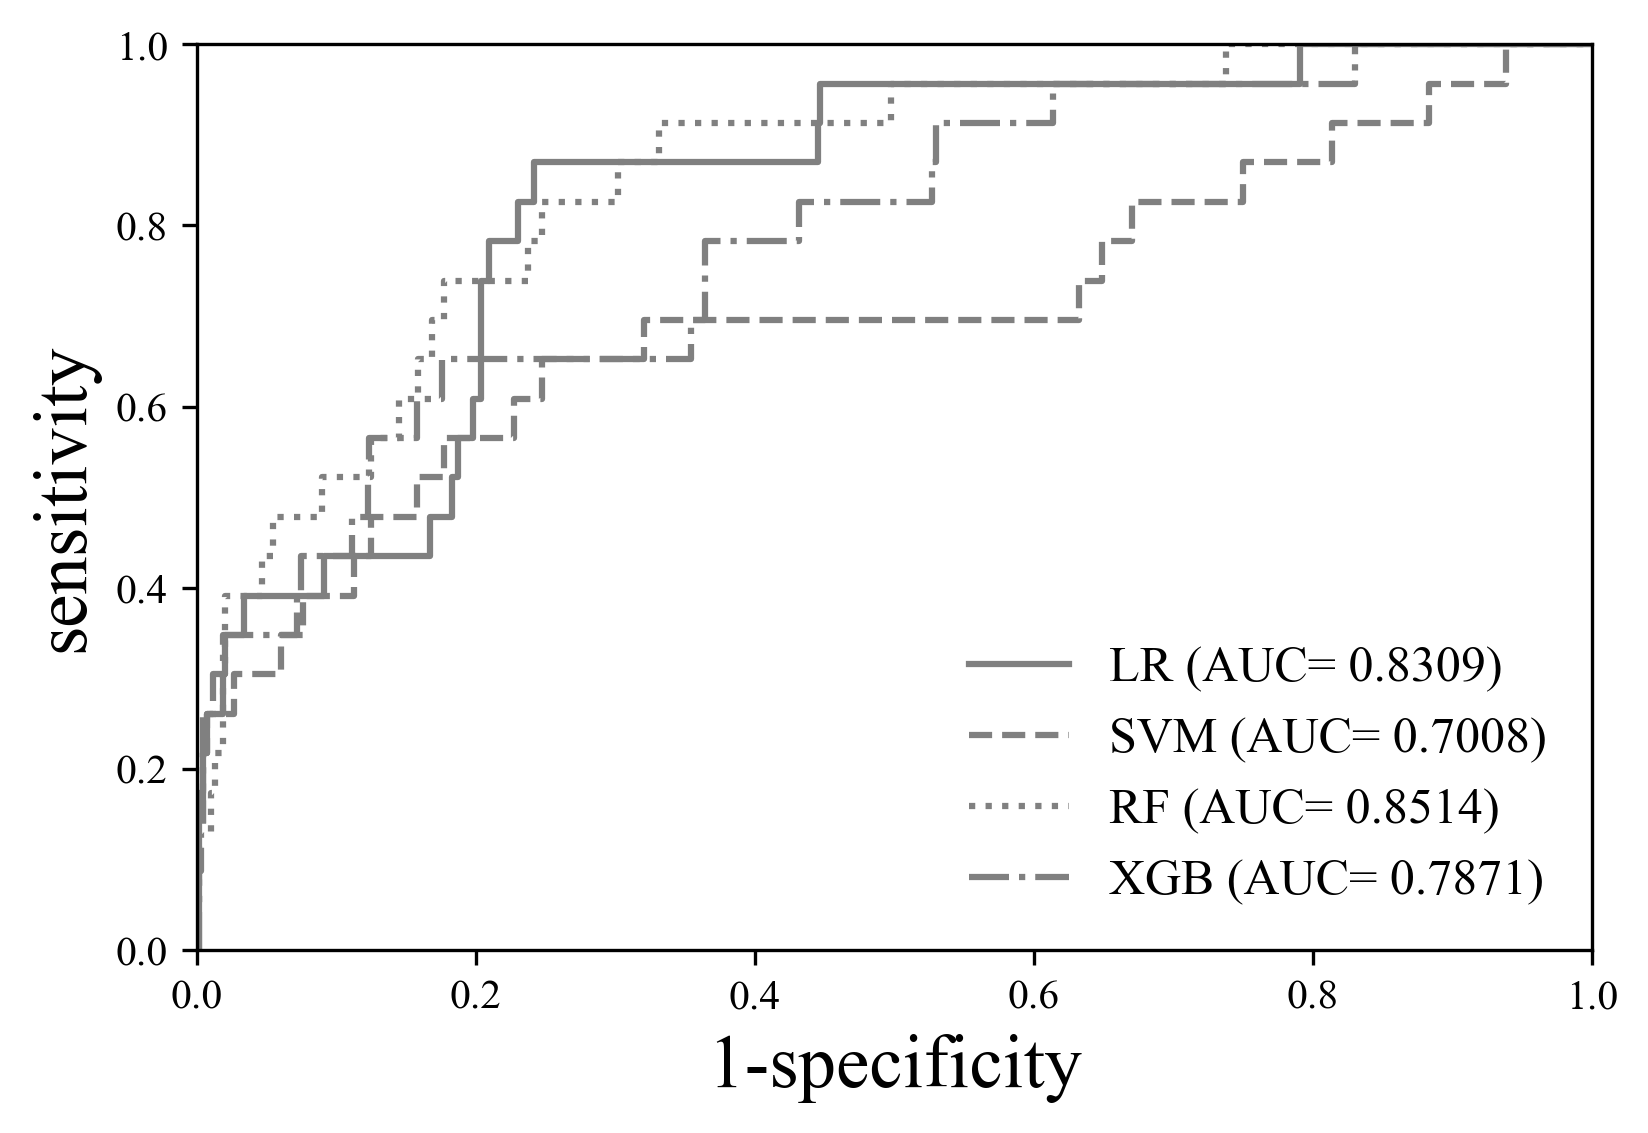

490
490
490
490 735
490 735
490 735
490 735
490
490
490
490 735
490 735
490 735
490 735
490
490
490
490 735
490 735
490 735
490 735
490
490
490
490 735
490 735
490 735
490 735
490
490
490
490 735
490 735
490 735
490 735


LR
tn = 2366 fp = 7 fn = 62 tp = 15
SVM
tn = 2373 fp = 0 fn = 76 tp = 1
RF
tn = 2372 fp = 1 fn = 77 tp = 0
XGB
tn = 2363 fp = 10 fn = 69 tp = 8


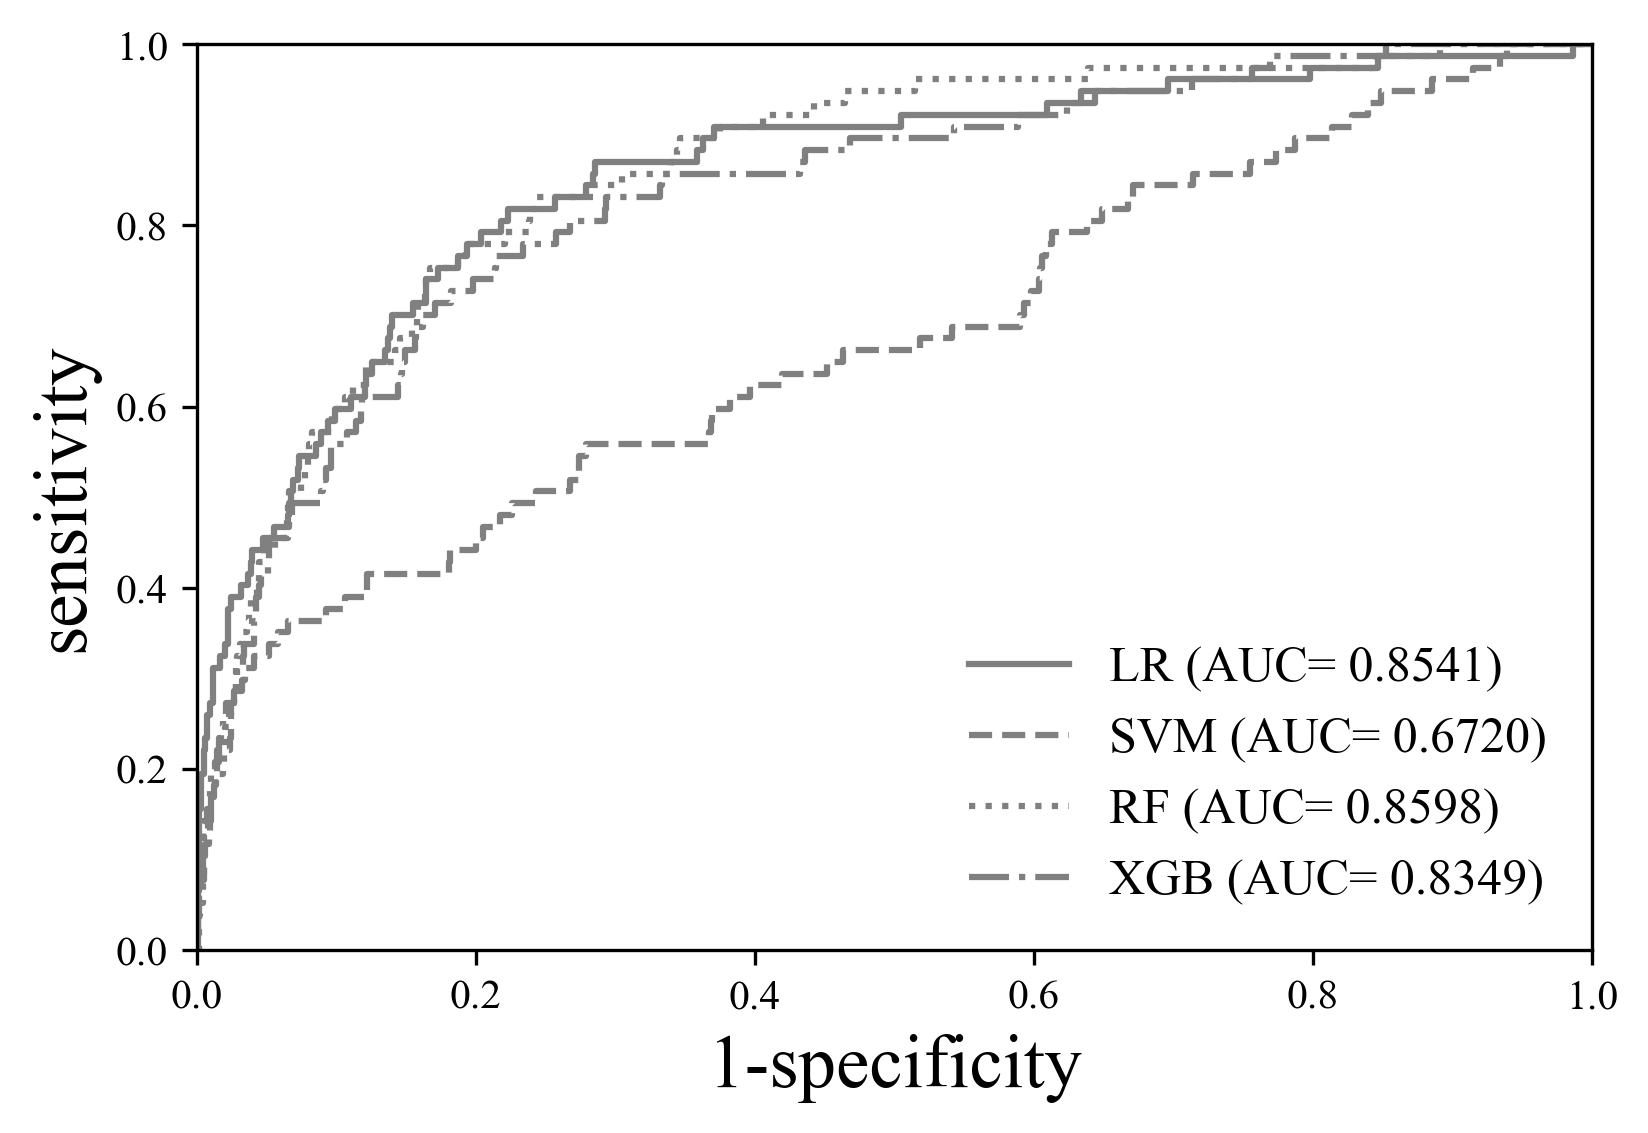

In [43]:
#오래걸렸죠? 이제 결과 확인
CVclass = classlist.copy()
train_x = [train_LR,train_SVM,train_RF,train_XGB]
test_x = [test_LR,test_SVM,test_RF,test_XGB]
classlist,ftr_importances = create_curve_select(classlist, train_x, train_y, test_x, test_y)

data_x = [data_LR,data_SVM,data_RF,data_XGB]

CV_data_x = data_x.copy()
CV_data_y = data_y.copy()

# DFS = CV_data_x.loc[:,con_col]
# CV_data_x = CV_data_x.drop(DFS,1)

# MM = StandardScaler()
# DFSMM = MM.fit_transform(DFS)
# DFS = pd.DataFrame(DFSMM, columns=con_col)
# CV_data_x = pd.concat([CV_data_x,DFS],1)

con_col = [con_LR,con_SVM,con_RF,con_XGB]

CVROC_select(CVclass,con_col,CV_data_x, CV_data_y)

In [44]:
train_XGB

Hypoxia  Renal_failure  BISAP  CTSI   BUN    Cr   Lipa1    Amy2
0         0.0            0.0    0.0   3.0  12.1  0.23    95.0    52.0
1         0.0            1.0    2.0   4.0  25.6  1.22   134.0    95.0
2         0.0            0.0    3.0   3.0  34.0  1.56  6045.0  1531.0
3         1.0            0.0    2.0   1.0   5.0  0.78  2348.0   677.0
4         0.0            0.0    0.0   3.0  10.7  0.96  2803.0   775.0
...       ...            ...    ...   ...   ...   ...     ...     ...
1710      0.0            0.0    0.0   3.0   6.0  0.37  1512.0   274.0
1711      0.0            0.0    0.0   2.0  13.6  0.86  5408.0   581.0
1712      0.0            0.0    1.0   4.0   7.0  1.00   456.0   161.0
1713      0.0            0.0    2.0   3.0  16.4  0.89   501.0   270.0
1714      1.0            0.0    2.0   4.0  10.9  0.89   742.0   107.0

[1715 rows x 8 columns]

           feature  weight_LR  weight_SVM  weight_RF  weight_XGB  meanscore
0    Renal_failure  -0.003261    0.000098        NaN   -0.003884  -0.002349
1            BISAP   0.041817         NaN   0.017416   -0.003346   0.018629
2             CTSI   0.069687    0.060979   0.078334    0.060027   0.067257
3              ALT  -0.000745         NaN   0.041646         NaN   0.020451
4              Glc   0.035918    0.021751        NaN         NaN   0.028835
5               Cr   0.011260         NaN        NaN    0.002186   0.006723
6             Amy2   0.052259    0.103407   0.013715    0.054439   0.055955
7            Lipa2   0.009001    0.063520        NaN         NaN   0.036260
8               MV   0.010955    0.000574        NaN         NaN   0.005765
9   Pseudoaneurysm  -0.000098         NaN        NaN         NaN  -0.000098
10             PLT   0.067440         NaN        NaN         NaN   0.067440
11             RRT        NaN    0.069651        NaN         NaN   0.069651
12         H

<AxesSubplot:>

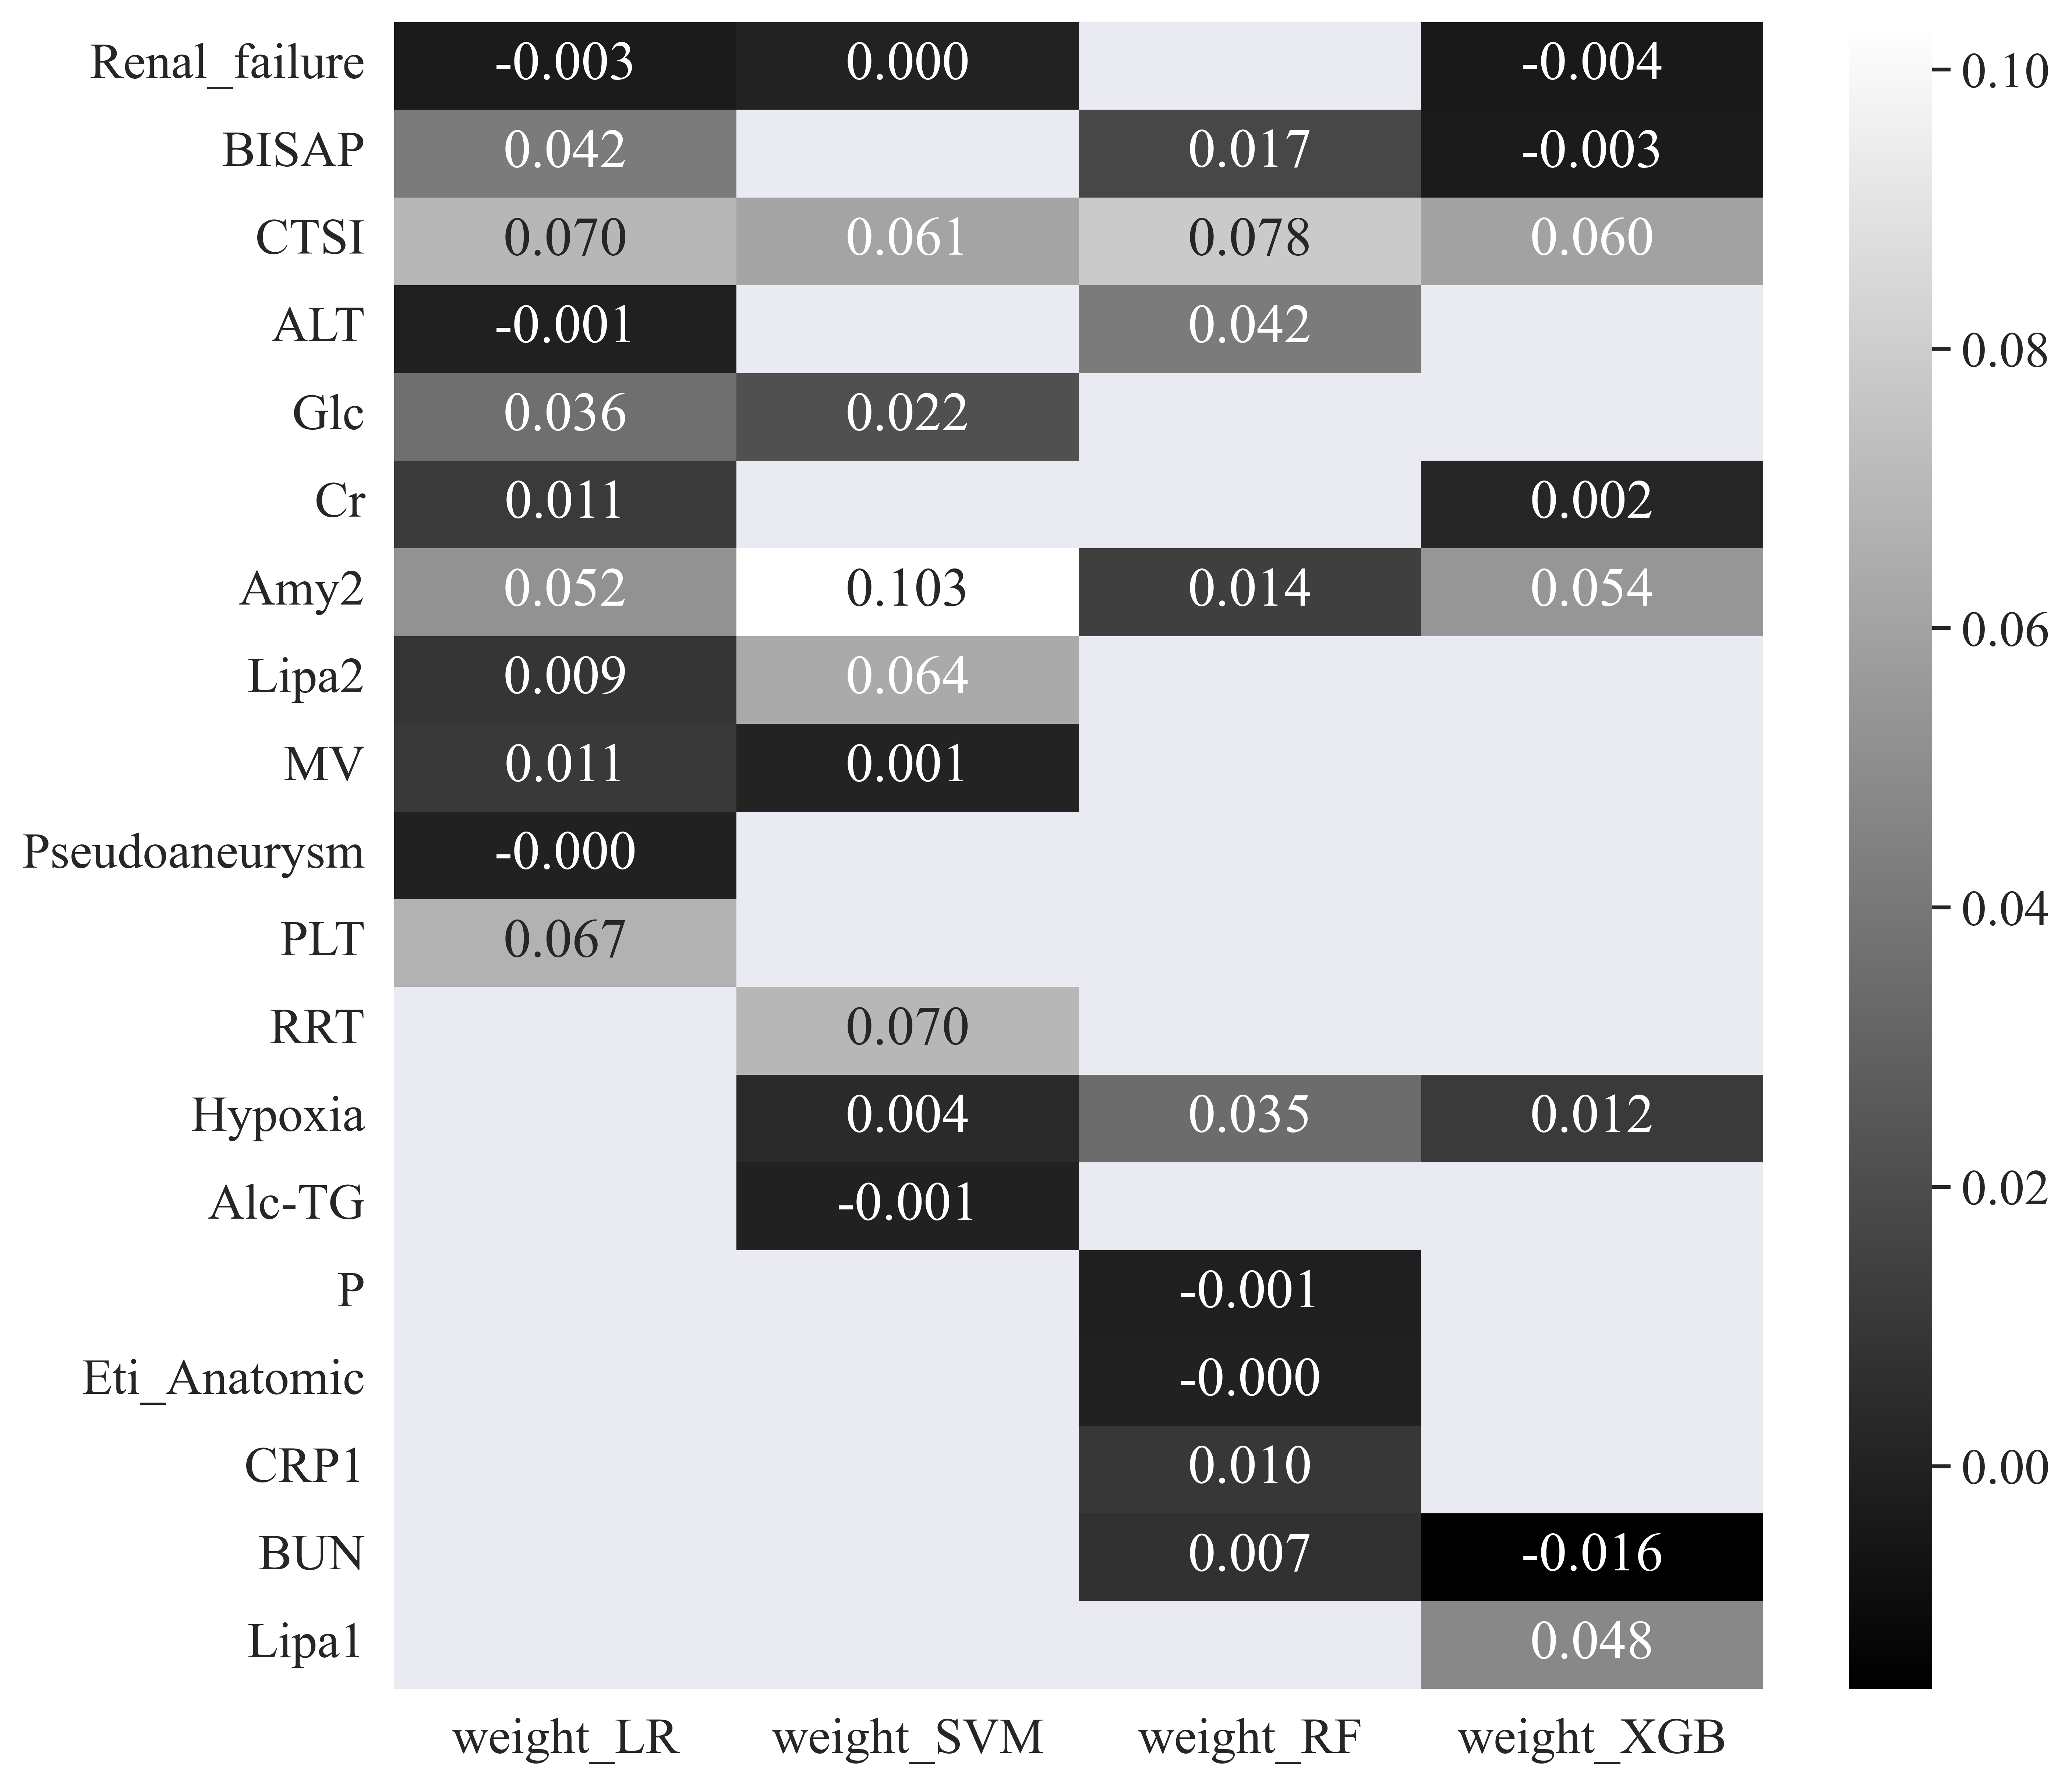

In [45]:
#위에서 뽑은 feature importance 히트맵으로 뽑기

print(ftr_importances)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 600
sns.set(font_scale=1.5, font='Times New Roman')
sns.heatmap(ftr_importances.iloc[:, [1, 2, 3,4]], cmap='gray',
            yticklabels=ftr_importances.iloc[:, 0], annot=True, fmt='0.3f')

In [46]:
# train_x = train_x.drop("Sex_M",1)
# test_x = test_x.drop("Sex_M",1)
# data_x = data_x.drop("Sex_M",1)

#오래걸렸죠? 이제 결과 확인
CVclass = classlist.copy()
classlist,ftr_importances = create_curve(classlist, train_x, train_y, test_x, test_y)

CV_data_x = data_x.copy()
CV_data_y = data_y.copy()

# DFS = CV_data_x.loc[:,con_col]
# CV_data_x = CV_data_x.drop(DFS,1)

# MM = StandardScaler()
# DFSMM = MM.fit_transform(DFS)
# DFS = pd.DataFrame(DFSMM, columns=con_col)
# CV_data_x = pd.concat([CV_data_x,DFS],1)


CVROC(CVclass,con_col,CV_data_x, CV_data_y)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 1715) + inhomogeneous part.

In [ ]:
ftr_importances

In [ ]:
for i, (train, test) in enumerate(cv.split(CV_data_x[3], CV_data_y)):
    print(train)

In [ ]:
CV_data_x[1].columns